In [1]:
%matplotlib inline
import matplotlib as mlp
# mlp.rcParams['figure.dpi'] = 200

# diasbling warning messages
import warnings
warnings.filterwarnings("ignore")

# importing key libraries
import pandas as pd
pd.set_option('display.max_rows', None)
pd.options.display.float_format = '{:.2f}'.format

# numpy import
import numpy as np

# scipy import
import scipy.stats as stats
from math import sqrt

# importing datetime module
import datetime

# importing acquire module
import acquire
from acquire import get_zillow_dataset, \
                    null_df, \
                    drop_nulls, \
                    clean_zillow_dataset, \
                    train_validate_test_split

# importing data visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set(style = "darkgrid")

# sklearn data science library
from sklearn.impute import KNNImputer
from sklearn.impute import MissingIndicator
from sklearn.experimental import enable_iterative_imputer
from sklearn.metrics import mean_squared_error
from sklearn.impute import IterativeImputer
from sklearn.cluster import KMeans

from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.feature_selection import SelectKBest, RFE, f_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance

In [2]:
# data acquisition and preparation

df = get_zillow_dataset()
print(df.shape)

(52319, 68)


In [3]:
# initial clean of dataset 
# where: feature and record null % > 80% are dropped

df = clean_zillow_dataset(df)
df.head()

parcel_id  home_value  logerror  bathroom_count  bedroom_count  \
0  14297519  1023282.00      0.03            3.50           4.00   
1  17052889   464000.00      0.06            1.00           2.00   
2  14186244   564778.00      0.01            2.00           3.00   
3  12177905   145143.00     -0.10            3.00           4.00   
4  12095076   773303.00     -0.00            3.00           4.00   

   living_sq_feet  county_by_fips    latitude     longitude  property_sq_feet  \
0         3100.00   Orange County 33634931.00 -117869207.00           4506.00   
1         1465.00  Ventura County 34449266.00 -119281531.00          12647.00   
2         1243.00   Orange County 33886168.00 -117823170.00           8432.00   
3         2376.00       LA County 34245180.00 -118240722.00          13038.00   
4         2962.00       LA County 34145202.00 -118179824.00          63000.00   

  county_zoning_code blockgroup_assignment transaction_date  year_built  
0                122       60590630.072012       2017-01-01     1998.00  
1               1110     61110010.02300601       2017-01-01     1967.00  
2                122       60590218.022012       2017-01-01     1962.00  
3               0101     60373001.00100601       2017-01-01     1970.00  
4               0101       60374608.001014       2017-01-01     1950.00

In [4]:
# calculating and adding age of the home thru 2017

df = acquire.age_of_homes(df)
df.head()

dataframe shape: (52238, 15)


parcel_id  home_value  logerror  bathroom_count  bedroom_count  \
0  14297519  1023282.00      0.03            3.50           4.00   
1  17052889   464000.00      0.06            1.00           2.00   
2  14186244   564778.00      0.01            2.00           3.00   
3  12177905   145143.00     -0.10            3.00           4.00   
4  12095076   773303.00     -0.00            3.00           4.00   

   living_sq_feet  county_by_fips    latitude     longitude  property_sq_feet  \
0         3100.00   Orange County 33634931.00 -117869207.00           4506.00   
1         1465.00  Ventura County 34449266.00 -119281531.00          12647.00   
2         1243.00   Orange County 33886168.00 -117823170.00           8432.00   
3         2376.00       LA County 34245180.00 -118240722.00          13038.00   
4         2962.00       LA County 34145202.00 -118179824.00          63000.00   

  county_zoning_code blockgroup_assignment transaction_date  year_built  \
0                122       60590630.072012       2017-01-01     1998.00   
1               1110     61110010.02300601       2017-01-01     1967.00   
2                122       60590218.022012       2017-01-01     1962.00   
3               0101     60373001.00100601       2017-01-01     1970.00   
4               0101       60374608.001014       2017-01-01     1950.00   

   home_age  
0     19.00  
1     50.00  
2     55.00  
3     47.00  
4     67.00

In [5]:
# retrieving numerical column lower/upper bound outliers 

holder = []
num_lst = df.select_dtypes("number").columns.tolist()
num_lst = [ele for ele in num_lst if ele not in ("parcel_id", 'longitude', 'latitude', 'blockgroup_assignment')]
k = 1.5

# determining continuous features/columns
for col in df[num_lst]:
    
    # determing 1st and 3rd quartile
    q1, q3 = df[col].quantile([.25, 0.75])
    
    # calculate interquartile range
    iqr = q3 - q1
    
    # set feature/data lower bound limit
    lower_bound = q1 - k * iqr

    # set feature/data upperbound limit
    upper_bound = q3 + k * iqr
    
    metrics = { 
        "column": col,
        "column type": df[col].dtype,
        "iqr": round(iqr, 5),
        "lower_bound": round(lower_bound, 5),
        "lower_outliers": len(df[df[col] < lower_bound]),
        "upper_bound": round(upper_bound, 5),
        "upper_outliers": len(df[df[col] > upper_bound])
    }

    holder.append(metrics)

num_outliers = pd.DataFrame(holder)
num_outliers

column column type       iqr  lower_bound  lower_outliers  \
0        home_value     float64 424963.00   -443469.50               0   
1          logerror     float64      0.07        -0.12            2625   
2    bathroom_count     float64      1.00         0.50              46   
3     bedroom_count     float64      1.00         1.50             670   
4    living_sq_feet     float64   1038.00      -289.00               0   
5  property_sq_feet     float64   3204.00       775.00              42   
6        year_built     float64     29.00      1906.50             240   
7          home_age     float64     29.00        -5.50               0   

   upper_bound  upper_outliers  
0   1256382.50            3507  
1         0.14            3769  
2         4.50            1577  
3         5.50             777  
4      3863.00            2272  
5     13591.00            5528  
6      2022.50               0  
7       110.50             240

In [6]:
df.columns.tolist()

['parcel_id',
 'home_value',
 'logerror',
 'bathroom_count',
 'bedroom_count',
 'living_sq_feet',
 'county_by_fips',
 'latitude',
 'longitude',
 'property_sq_feet',
 'county_zoning_code',
 'blockgroup_assignment',
 'transaction_date',
 'year_built',
 'home_age']

In [7]:
# shape before cleaning outliers

df.shape

(52238, 15)

In [8]:
# cleaning identified outlier limits

df = acquire.zillow_outliers(df)
df.shape

dataframe shape: (38534, 15)


(38534, 15)

In [9]:
# adding transactions by month columns

df = acquire.clean_months(df)
df.head()

parcel_id  home_value  logerror  bathroom_count  bedroom_count  \
0  14297519  1023282.00      0.03            3.50           4.00   
1  17052889   464000.00      0.06            1.00           2.00   
2  14186244   564778.00      0.01            2.00           3.00   
3  12177905   145143.00     -0.10            3.00           4.00   
5  12069064   218552.00      0.10            1.00           2.00   

   living_sq_feet  county_by_fips    latitude     longitude  property_sq_feet  \
0         3100.00   Orange County 33634931.00 -117869207.00           4506.00   
1         1465.00  Ventura County 34449266.00 -119281531.00          12647.00   
2         1243.00   Orange County 33886168.00 -117823170.00           8432.00   
3         2376.00       LA County 34245180.00 -118240722.00          13038.00   
5          738.00       LA County 34149214.00 -118239357.00           4214.00   

  county_zoning_code blockgroup_assignment  year_built  home_age  \
0                122       60590630.072012     1998.00     19.00   
1               1110     61110010.02300601     1967.00     50.00   
2                122       60590218.022012     1962.00     55.00   
3               0101     60373001.00100601     1970.00     47.00   
5               0100       60373020.041001     1922.00     95.00   

  transaction_month  
0           January  
1           January  
2           January  
3           January  
5           January

In [10]:
# df['example1'] = pd.to_datetime(df.transaction_date).dt.to_period('m')
# df['example1'].head()

In [11]:
# df['example2'] = pd.to_datetime(df.transaction_date).dt.strftime('%m/%Y')
# df.example2.head()

In [12]:
# dataframe info

sorted_cols = df.columns.sort_values()
df[sorted_cols].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38534 entries, 0 to 52318
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   bathroom_count         38534 non-null  float64
 1   bedroom_count          38534 non-null  float64
 2   blockgroup_assignment  38534 non-null  object 
 3   county_by_fips         38534 non-null  object 
 4   county_zoning_code     38534 non-null  object 
 5   home_age               38521 non-null  float64
 6   home_value             38533 non-null  float64
 7   latitude               38534 non-null  float64
 8   living_sq_feet         38534 non-null  float64
 9   logerror               38534 non-null  float64
 10  longitude              38534 non-null  float64
 11  parcel_id              38534 non-null  object 
 12  property_sq_feet       38307 non-null  float64
 13  transaction_month      38534 non-null  object 
 14  year_built             38521 non-null  float64
dtypes:

In [13]:
# checking initial dataset nulls and percentage of dataframe features

remaining_nulls = null_df(df)
remaining_nulls

Total Null  Feature Null %
property_sq_feet              227            0.01
year_built                     13            0.00
home_age                       13            0.00
home_value                      1            0.00
parcel_id                       0            0.00
logerror                        0            0.00
bathroom_count                  0            0.00
bedroom_count                   0            0.00
living_sq_feet                  0            0.00
county_by_fips                  0            0.00
latitude                        0            0.00
longitude                       0            0.00
county_zoning_code              0            0.00
blockgroup_assignment           0            0.00
transaction_month               0            0.00

In [14]:
# summing total number of outliers per continuous feature - target variable

acquire.sum_outliers(df)

Feature  Upper_Bound  Total Outliers
0    bathroom_count         3.25            1495
1  property_sq_feet     11269.00            1456
2    living_sq_feet      3248.00             900
3        home_value   1047609.50             758
4          home_age       107.50             102

In [15]:
# identifying continuous variables/features:

num_lst = df.select_dtypes("number").columns.tolist()
num_lst = [ele for ele in num_lst if ele not in ("logerror", "parcel_id", "year_built")]
num_lst

['home_value',
 'bathroom_count',
 'bedroom_count',
 'living_sq_feet',
 'latitude',
 'longitude',
 'property_sq_feet',
 'home_age']

In [16]:
# let's handle the outliers using a upper bound "capping" method

# df = acquire.clean_outliers(df)
df.head()

parcel_id  home_value  logerror  bathroom_count  bedroom_count  \
0  14297519  1023282.00      0.03            3.50           4.00   
1  17052889   464000.00      0.06            1.00           2.00   
2  14186244   564778.00      0.01            2.00           3.00   
3  12177905   145143.00     -0.10            3.00           4.00   
5  12069064   218552.00      0.10            1.00           2.00   

   living_sq_feet  county_by_fips    latitude     longitude  property_sq_feet  \
0         3100.00   Orange County 33634931.00 -117869207.00           4506.00   
1         1465.00  Ventura County 34449266.00 -119281531.00          12647.00   
2         1243.00   Orange County 33886168.00 -117823170.00           8432.00   
3         2376.00       LA County 34245180.00 -118240722.00          13038.00   
5          738.00       LA County 34149214.00 -118239357.00           4214.00   

  county_zoning_code blockgroup_assignment  year_built  home_age  \
0                122       60590630.072012     1998.00     19.00   
1               1110     61110010.02300601     1967.00     50.00   
2                122       60590218.022012     1962.00     55.00   
3               0101     60373001.00100601     1970.00     47.00   
5               0100       60373020.041001     1922.00     95.00   

  transaction_month  
0           January  
1           January  
2           January  
3           January  
5           January

In [17]:
# checking the dataframe shape after capping outliers

df.shape

(38534, 15)

----
### **``splitting zillow dataset and cleaning remaining nulls/missing values:``**

In [18]:
# splitting the dataset to 1. fill-in remaining nulls and 2. determine outlier cutoffs

train, validate, test = train_validate_test_split(df)

train shape: (21578, 15)
validate shape: (9249, 15)
test shape: (7707, 15)


In [19]:
# creating a new continuous feature list in datasets

num_lst = train.select_dtypes("number").columns.tolist()
num_lst = [ele for ele in num_lst if ele not in ("logerror", "home_value")]
num_lst

['bathroom_count',
 'bedroom_count',
 'living_sq_feet',
 'latitude',
 'longitude',
 'property_sq_feet',
 'year_built',
 'home_age']

In [20]:
# checking train dataset for remaining nulls

null_df = null_df(train)
null_df

Total Null  Feature Null %
property_sq_feet              131            0.01
year_built                      6            0.00
home_age                        6            0.00
home_value                      1            0.00
parcel_id                       0            0.00
logerror                        0            0.00
bathroom_count                  0            0.00
bedroom_count                   0            0.00
living_sq_feet                  0            0.00
county_by_fips                  0            0.00
latitude                        0            0.00
longitude                       0            0.00
county_zoning_code              0            0.00
blockgroup_assignment           0            0.00
transaction_month               0            0.00

In [21]:
# checking dataframe after split

train.head()

parcel_id  home_value  logerror  bathroom_count  bedroom_count  \
49143  11279487    74239.00     -0.02            1.00           3.00   
18505  14235131   426984.00     -0.02            2.50           3.00   
1594   12461319   399808.00      0.02            2.00           3.00   
35506  14139772    71763.00     -0.06            2.00           3.00   
11229  14491761   354226.00     -0.03            1.00           2.00   

       living_sq_feet county_by_fips    latitude     longitude  \
49143          943.00      LA County 34695455.00 -118167705.00   
18505         1436.00  Orange County 33794700.00 -117823000.00   
1594          1470.00      LA County 33843316.00 -118173744.00   
35506         1403.00  Orange County 33905449.00 -117892188.00   
11229          936.00  Orange County 33625277.00 -117662397.00   

       property_sq_feet county_zoning_code blockgroup_assignment  year_built  \
49143           7834.00               0100     60379010.08200601     1955.00   
18505           2490.00                122          60590758.153     1989.00   
1594            6336.00               0100    60375715.032005005     1942.00   
35506           7770.00                122    60590015.054018006     1963.00   
11229           5000.00                122     60590320.28100699     1972.00   

       home_age transaction_month  
49143     62.00         September  
18505     28.00             April  
1594      75.00           January  
35506     54.00              June  
11229     45.00             March

In [22]:
# using sklearn's iterative imputer to fill-in remaining nulls

def train_iterative_imputer(train_df):

        # placeholder for continuous features
        num_lst = [
        'home_value',
        'bathroom_count',
        'bedroom_count',
        'living_sq_feet',
        'latitude',
        'longitude',
        'property_sq_feet',
        'blockgroup_assignment',
        'year_built',
        'home_age']

        # creating the "thing"
        imputer = IterativeImputer(
                missing_values = np.nan, \
                skip_complete = True, \
                random_state = 123)
        
        # fitting the "thing" and transforming it
        imputed = imputer.fit_transform(train_df[num_lst])

           # create a new dataframe with learned imputed data
        train_df_imputed = pd.DataFrame(imputed, index = train_df.index)

        # filling in missing values from learned imputer
        train_df[num_lst] = train_df_imputed

        # return the new imputed df
        return train_df

In [23]:
# let's fit the imputer and return it

train_imputed = train_iterative_imputer(train)
train_imputed.isnull().sum()

parcel_id                0
home_value               0
logerror                 0
bathroom_count           0
bedroom_count            0
living_sq_feet           0
county_by_fips           0
latitude                 0
longitude                0
property_sq_feet         0
county_zoning_code       0
blockgroup_assignment    0
year_built               0
home_age                 0
transaction_month        0
dtype: int64

In [24]:
# let's transform validate and test datasets

num_lst = [
        'bathroom_count',
        'bedroom_count',
        'living_sq_feet',
        'latitude',
        'longitude',
        'property_sq_feet',
        'blockgroup_assignment',
        'year_built',
        'home_age']

# creating the "thing"
imputer = IterativeImputer(
        missing_values = np.nan, \
        skip_complete = True, \
        random_state = 123)

# fitting the "thing" and transforming it
imputed = imputer.fit(train[num_lst])

val_imputed = imputed.transform(validate[num_lst])
X_validate_imputed = pd.DataFrame(val_imputed, index = validate.index)
validate[num_lst] = X_validate_imputed
validate_imputed = validate

test_imputed = imputed.transform(test[num_lst])
test_imputed = pd.DataFrame(test_imputed, index = test.index)
test[num_lst] = test_imputed
test_imputed = test

# checking the dataset for nulls
print('null results in: validate')
print('----------------------------|---------')
print(f'{validate_imputed.isnull().sum()}')
print()
print('null results in: test')
print('----------------------------|---------')
print(f'{test_imputed.isnull().sum()}')

null results in: validate
----------------------------|---------
parcel_id                0
home_value               0
logerror                 0
bathroom_count           0
bedroom_count            0
living_sq_feet           0
county_by_fips           0
latitude                 0
longitude                0
property_sq_feet         0
county_zoning_code       0
blockgroup_assignment    0
year_built               0
home_age                 0
transaction_month        0
dtype: int64

null results in: test
----------------------------|---------
parcel_id                0
home_value               0
logerror                 0
bathroom_count           0
bedroom_count            0
living_sq_feet           0
county_by_fips           0
latitude                 0
longitude                0
property_sq_feet         0
county_zoning_code       0
blockgroup_assignment    0
year_built               0
home_age                 0
transaction_month        0
dtype: int64


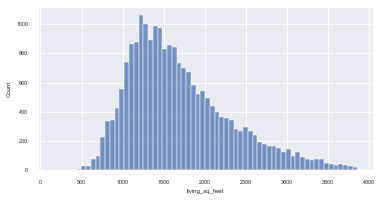

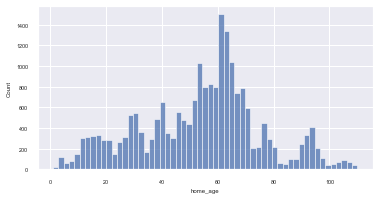

In [25]:
# let's bin the following features:

# living sq. feet = relative size of the home (<1K, 1-2K, 2-3K, 4K, etc.)
# home age = relative age of the home (e.g., recent build, mid-century, early-century, last-century, etc.)

for col in train_imputed[["living_sq_feet", "home_age"]]:
    plt.figure(figsize = (6, 3))
    sns.set(font_scale = .5)
    
    sns.histplot(train_imputed[col])
    plt.show()


In [26]:
pd.qcut(
    train_imputed["home_age"],
    q = 4).unique()

[(57.0, 67.0], (0.999, 40.0], (67.0, 110.0], (40.0, 57.0]]
Categories (4, interval[float64, right]): [(0.999, 40.0] < (40.0, 57.0] < (57.0, 67.0] < (67.0, 110.0]]

In [27]:
# pandas cut method on Home Age
# [(0.999, 38.0] > (38.0, 57.0] > (57.0, 67.0], (67.0, 110.5]]

age_labels = ["new_century", "late_20th_century", "mid_20th_century", "early_20th_century"]

train_imputed["home_age_binned"] = pd.qcut(
    train_imputed["home_age"],
    q = 4,
    labels = age_labels)

validate_imputed["home_age_binned"] = pd.qcut(
    validate_imputed["home_age"], 
    q = 4, 
    labels = age_labels)

test_imputed["home_age_binned"] = pd.qcut(
    test_imputed["home_age"], 
    q = 4, 
    labels = age_labels)

train_imputed.head()

parcel_id  home_value  logerror  bathroom_count  bedroom_count  \
49143  11279487    74239.00     -0.02            1.00           3.00   
18505  14235131   426984.00     -0.02            2.50           3.00   
1594   12461319   399808.00      0.02            2.00           3.00   
35506  14139772    71763.00     -0.06            2.00           3.00   
11229  14491761   354226.00     -0.03            1.00           2.00   

       living_sq_feet county_by_fips    latitude     longitude  \
49143          943.00      LA County 34695455.00 -118167705.00   
18505         1436.00  Orange County 33794700.00 -117823000.00   
1594          1470.00      LA County 33843316.00 -118173744.00   
35506         1403.00  Orange County 33905449.00 -117892188.00   
11229          936.00  Orange County 33625277.00 -117662397.00   

       property_sq_feet county_zoning_code  blockgroup_assignment  year_built  \
49143           7834.00               0100            60379010.08     1955.00   
18505           2490.00                122            60590758.15     1989.00   
1594            6336.00               0100            60375715.03     1942.00   
35506           7770.00                122            60590015.05     1963.00   
11229           5000.00                122            60590320.28     1972.00   

       home_age transaction_month     home_age_binned  
49143     62.00         September    mid_20th_century  
18505     28.00             April         new_century  
1594      75.00           January  early_20th_century  
35506     54.00              June   late_20th_century  
11229     45.00             March   late_20th_century

In [28]:
# home time period

train_imputed[train_imputed["home_age_binned"] == "early_20th_century"].year_built.min()

# 1977 - 2015
# 1960 - 1976
# 1950 - 1959
# 1907 - 1949

1907.0

In [29]:
# checking validate dataset

validate_imputed.head()

parcel_id  home_value  logerror  bathroom_count  bedroom_count  \
20767  12496238   105772.00     -0.04            2.00           4.00   
29240  10970562    58144.00      0.03            1.00           3.00   
3001   10960738   652384.00      0.05            2.00           3.00   
45010  11099747   534051.00      0.06            2.00           4.00   
41382  11974853   449755.00      0.09            2.00           3.00   

       living_sq_feet county_by_fips    latitude     longitude  \
20767         1557.00      LA County 33814961.00 -118116863.00   
29240          987.00      LA County 34315177.00 -118422805.00   
3001          1260.00      LA County 34163419.00 -118330574.00   
45010         1640.00      LA County 34227495.00 -118560561.00   
41382         1548.00      LA County 34131329.00 -118186004.00   

       property_sq_feet county_zoning_code  blockgroup_assignment  year_built  \
20767           5420.00               0100            60375741.00     1951.00   
29240           4991.00               0100            60371061.12     1947.00   
3001            7071.00               0100            60373115.00     1928.00   
45010          13357.00               0100            60371134.01     1960.00   
41382           2869.00               0100            60371815.00     1924.00   

       home_age transaction_month     home_age_binned  
20767     66.00             April    mid_20th_century  
29240     70.00              June  early_20th_century  
3001      89.00           January  early_20th_century  
45010     57.00            August   late_20th_century  
41382     93.00              July  early_20th_century

In [30]:
pd.qcut(
    train_imputed["living_sq_feet"], \
    q = 4).unique()

[(151.999, 1236.0], (1236.0, 1566.0], (1566.0, 2044.0], (2044.0, 3853.0]]
Categories (4, interval[float64, right]): [(151.999, 1236.0] < (1236.0, 1566.0] < (1566.0, 2044.0] < (2044.0, 3853.0]]

In [31]:
# pandas cut method on Living Sq. Feet

sq_ft_labels = ["360_to_1240_sqfeet", "1241_to_1565_sqfeet", "1566_to_2036_sqfeet", "2037_to_3855_sqfeet"]

train_imputed["living_sqfeet_binned"] = pd.qcut(
    train_imputed["living_sq_feet"], \
    q = 4, \
    labels = sq_ft_labels)

validate_imputed["living_sqfeet_binned"] = pd.qcut(
    validate_imputed["living_sq_feet"], \
    q = 4, \
    labels = sq_ft_labels)

test_imputed["living_sqfeet_binned"] = pd.qcut(
    test_imputed["living_sq_feet"], \
    q = 4, \
    labels = sq_ft_labels)

train_imputed.head()

parcel_id  home_value  logerror  bathroom_count  bedroom_count  \
49143  11279487    74239.00     -0.02            1.00           3.00   
18505  14235131   426984.00     -0.02            2.50           3.00   
1594   12461319   399808.00      0.02            2.00           3.00   
35506  14139772    71763.00     -0.06            2.00           3.00   
11229  14491761   354226.00     -0.03            1.00           2.00   

       living_sq_feet county_by_fips    latitude     longitude  \
49143          943.00      LA County 34695455.00 -118167705.00   
18505         1436.00  Orange County 33794700.00 -117823000.00   
1594          1470.00      LA County 33843316.00 -118173744.00   
35506         1403.00  Orange County 33905449.00 -117892188.00   
11229          936.00  Orange County 33625277.00 -117662397.00   

       property_sq_feet county_zoning_code  blockgroup_assignment  year_built  \
49143           7834.00               0100            60379010.08     1955.00   
18505           2490.00                122            60590758.15     1989.00   
1594            6336.00               0100            60375715.03     1942.00   
35506           7770.00                122            60590015.05     1963.00   
11229           5000.00                122            60590320.28     1972.00   

       home_age transaction_month     home_age_binned living_sqfeet_binned  
49143     62.00         September    mid_20th_century   360_to_1240_sqfeet  
18505     28.00             April         new_century  1241_to_1565_sqfeet  
1594      75.00           January  early_20th_century  1241_to_1565_sqfeet  
35506     54.00              June   late_20th_century  1241_to_1565_sqfeet  
11229     45.00             March   late_20th_century   360_to_1240_sqfeet

In [32]:
# let's create a transaction seasons/yearly quarter column by using transaction months

sorted(train_imputed["transaction_month"].unique())

['April',
 'August',
 'February',
 'January',
 'July',
 'June',
 'March',
 'May',
 'September']

In [33]:
# let's create the quarter columns

# train dataset
train_imputed["q1_transaction"] = (train_imputed["transaction_month"] == "January") | (train_imputed["transaction_month"] == "February") | (train_imputed["transaction_month"] == "March")
train_imputed["q2_transaction"] = (train_imputed["transaction_month"] == "April") | (train_imputed["transaction_month"] == "May") | (train_imputed["transaction_month"] == "June")
train_imputed["q3_transaction"] = (train_imputed["transaction_month"] == "July") | (train_imputed["transaction_month"] == "August") | (train_imputed["transaction_month"] == "September")

# validate dataset
validate_imputed["q1_transaction"] = (validate_imputed["transaction_month"] == "January") | (validate_imputed["transaction_month"] == "February") | (validate_imputed["transaction_month"] == "March")
validate_imputed["q2_transaction"] = (validate_imputed["transaction_month"] == "April") | (validate_imputed["transaction_month"] == "May") | (validate_imputed["transaction_month"] == "June")
validate_imputed["q3_transaction"] = (validate_imputed["transaction_month"] == "July") | (validate_imputed["transaction_month"] == "August") | (validate_imputed["transaction_month"] == "September")

# test dataset
test_imputed["q1_transaction"] = (test_imputed["transaction_month"] == "January") | (test_imputed["transaction_month"] == "February") | (test_imputed["transaction_month"] == "March")
test_imputed["q2_transaction"] = (test_imputed["transaction_month"] == "April") | (test_imputed["transaction_month"] == "May") | (test_imputed["transaction_month"] == "June")
test_imputed["q3_transaction"] = (test_imputed["transaction_month"] == "July") | (test_imputed["transaction_month"] == "August") | (test_imputed["transaction_month"] == "September")


train_imputed.head()

parcel_id  home_value  logerror  bathroom_count  bedroom_count  \
49143  11279487    74239.00     -0.02            1.00           3.00   
18505  14235131   426984.00     -0.02            2.50           3.00   
1594   12461319   399808.00      0.02            2.00           3.00   
35506  14139772    71763.00     -0.06            2.00           3.00   
11229  14491761   354226.00     -0.03            1.00           2.00   

       living_sq_feet county_by_fips    latitude     longitude  \
49143          943.00      LA County 34695455.00 -118167705.00   
18505         1436.00  Orange County 33794700.00 -117823000.00   
1594          1470.00      LA County 33843316.00 -118173744.00   
35506         1403.00  Orange County 33905449.00 -117892188.00   
11229          936.00  Orange County 33625277.00 -117662397.00   

       property_sq_feet county_zoning_code  blockgroup_assignment  year_built  \
49143           7834.00               0100            60379010.08     1955.00   
18505           2490.00                122            60590758.15     1989.00   
1594            6336.00               0100            60375715.03     1942.00   
35506           7770.00                122            60590015.05     1963.00   
11229           5000.00                122            60590320.28     1972.00   

       home_age transaction_month     home_age_binned living_sqfeet_binned  \
49143     62.00         September    mid_20th_century   360_to_1240_sqfeet   
18505     28.00             April         new_century  1241_to_1565_sqfeet   
1594      75.00           January  early_20th_century  1241_to_1565_sqfeet   
35506     54.00              June   late_20th_century  1241_to_1565_sqfeet   
11229     45.00             March   late_20th_century   360_to_1240_sqfeet   

       q1_transaction  q2_transaction  q3_transaction  
49143           False           False            True  
18505           False            True           False  
1594             True           False           False  
35506           False            True           False  
11229            True           False           False

In [34]:
# let's look at the dataframe column types

train_imputed.dtypes

parcel_id                  object
home_value                float64
logerror                  float64
bathroom_count            float64
bedroom_count             float64
living_sq_feet            float64
county_by_fips             object
latitude                  float64
longitude                 float64
property_sq_feet          float64
county_zoning_code         object
blockgroup_assignment     float64
year_built                float64
home_age                  float64
transaction_month          object
home_age_binned          category
living_sqfeet_binned     category
q1_transaction               bool
q2_transaction               bool
q3_transaction               bool
dtype: object

In [35]:
# listing discrete/categorical and continuous features

from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype

disc_features = []
num_features = []

for col in list(train_imputed.columns):
    if is_numeric_dtype(train_imputed[col]):
        num_features.append(col)
    
    else: disc_features.append(col)

print(f'discrete feature:\n{disc_features}')
print('-------')
print(f'continuous feature:\n{num_features}')

discrete feature:
['parcel_id', 'county_by_fips', 'county_zoning_code', 'transaction_month', 'home_age_binned', 'living_sqfeet_binned']
-------
continuous feature:
['home_value', 'logerror', 'bathroom_count', 'bedroom_count', 'living_sq_feet', 'latitude', 'longitude', 'property_sq_feet', 'blockgroup_assignment', 'year_built', 'home_age', 'q1_transaction', 'q2_transaction', 'q3_transaction']


-----
### **``hypothesis testing``**

In [36]:
# description of continuous variables

summary_stats = train_imputed.describe().T
summary_stats["range"] = summary_stats["max"] - summary_stats["min"]
summary_stats.sort_index()

count          mean       std           min  \
bathroom_count        21578.00          2.12      0.74          1.00   
bedroom_count         21578.00          3.21      0.81          1.00   
blockgroup_assignment 21578.00   60499822.77 210929.60   60371011.10   
home_age              21578.00         53.87     21.80          1.00   
home_value            21578.00     386313.64 255480.96      13524.00   
latitude              21578.00   34016097.94 274526.55   33340620.00   
living_sq_feet        21578.00       1697.63    625.71        152.00   
logerror              21578.00          0.00      0.05         -0.12   
longitude             21578.00 -118182707.25 357888.33 -119448392.00   
property_sq_feet      21578.00       6664.33   2209.09        780.00   
year_built            21578.00       1963.13     21.80       1907.00   

                                25%           50%           75%           max  \
bathroom_count                 2.00          2.00          2.50          4.50   
bedroom_count                  3.00          3.00          4.00          5.00   
blockgroup_assignment   60374034.06   60376212.01   60590524.17   61110091.00   
home_age                      40.00         57.00         67.00        110.00   
home_value                186353.50     348300.50     533003.75    1255855.00   
latitude                33821104.75   33993503.00   34189779.00   34718246.00   
living_sq_feet              1236.00       1566.00       2044.00       3853.00   
logerror                      -0.02          0.00          0.03          0.14   
longitude             -118380705.75 -118129180.50 -117923629.25 -117555373.00   
property_sq_feet            5396.00       6500.00       7728.00      13591.00   
year_built                  1950.00       1960.00       1977.00       2016.00   

                           range  
bathroom_count              3.50  
bedroom_count               4.00  
blockgroup_assignment  739079.90  
home_age                  109.00  
home_value            1242331.00  
latitude              1377626.00  
living_sq_feet           3701.00  
logerror                    0.26  
longitude             1893019.00  
property_sq_feet        12811.00  
year_built                109.00

In [37]:
# let's explore discrete vs. continuous variables/features

for col in list(train_imputed.columns):
    print(f'Feature: {col}')
    print(f'data type: {train_imputed[col].dtype}')
    print(f'number of unique values: {train_imputed[col].nunique()}')
    print()

Feature: parcel_id
data type: object
number of unique values: 21578

Feature: home_value
data type: float64
number of unique values: 17325

Feature: logerror
data type: float64
number of unique values: 21507

Feature: bathroom_count
data type: float64
number of unique values: 8

Feature: bedroom_count
data type: float64
number of unique values: 5

Feature: living_sq_feet
data type: float64
number of unique values: 2837

Feature: county_by_fips
data type: object
number of unique values: 3

Feature: latitude
data type: float64
number of unique values: 21229

Feature: longitude
data type: float64
number of unique values: 21268

Feature: property_sq_feet
data type: float64
number of unique values: 7311

Feature: county_zoning_code
data type: object
number of unique values: 12

Feature: blockgroup_assignment
data type: float64
number of unique values: 16377

Feature: year_built
data type: float64
number of unique values: 116

Feature: home_age
data type: float64
number of unique values: 116

In [38]:
# what is block group assignment

train_imputed["blockgroup_assignment"].head()

49143   60379010.08
18505   60590758.15
1594    60375715.03
35506   60590015.05
11229   60590320.28
Name: blockgroup_assignment, dtype: float64

In [39]:
# let's check the df information

train_imputed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21578 entries, 49143 to 34540
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   parcel_id              21578 non-null  object  
 1   home_value             21578 non-null  float64 
 2   logerror               21578 non-null  float64 
 3   bathroom_count         21578 non-null  float64 
 4   bedroom_count          21578 non-null  float64 
 5   living_sq_feet         21578 non-null  float64 
 6   county_by_fips         21578 non-null  object  
 7   latitude               21578 non-null  float64 
 8   longitude              21578 non-null  float64 
 9   property_sq_feet       21578 non-null  float64 
 10  county_zoning_code     21578 non-null  object  
 11  blockgroup_assignment  21578 non-null  float64 
 12  year_built             21578 non-null  float64 
 13  home_age               21578 non-null  float64 
 14  transaction_month      21578 non-n

In [40]:
# re-running feature lists

disc_features = []
num_features = []

for col in list(train_imputed.columns):
    if is_numeric_dtype(train_imputed[col]):
        num_features.append(col)
    
    else: disc_features.append(col)

print(f'discrete feature:\n{disc_features}')
print('-------')
print(f'continuous feature:\n{num_features}')

discrete feature:
['parcel_id', 'county_by_fips', 'county_zoning_code', 'transaction_month', 'home_age_binned', 'living_sqfeet_binned']
-------
continuous feature:
['home_value', 'logerror', 'bathroom_count', 'bedroom_count', 'living_sq_feet', 'latitude', 'longitude', 'property_sq_feet', 'blockgroup_assignment', 'year_built', 'home_age', 'q1_transaction', 'q2_transaction', 'q3_transaction']


In [41]:
# logerror absolute value

abs(train_imputed["logerror"]).mean()

0.034656891401959995

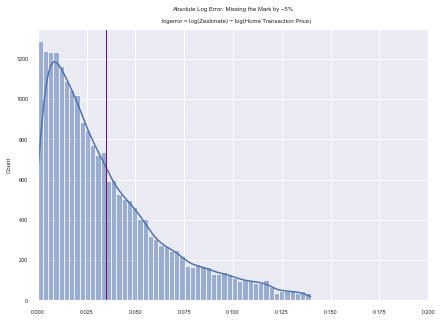

In [42]:
# let's look at absolute value for log error

plt.figure(figsize = (7, 5))
sns.set(font_scale = 0.5)

sns.histplot(
    abs(train_imputed["logerror"]), \
    # bins = 20, \
    kde = True)

plt.axvline(0.035, 
    linewidth = 1, 
    color = 'purple', 
    label = "mean")
    
# plt.text(0.055, 15500, "7.3% mean logerror", 
#     horizontalalignment = 'left', 
#     size = 'medium', 
#     color = 'purple', 
#     weight = 'semibold')

plt.title('''Absolute Log Error: Missing the Mark by ~5%\n
    logerror = log(Zestimate) − log(Home Transaction Price)''')
plt.xlabel(None)
plt.xlim(0, 0.2)
plt.show()

----
### ``Initial feature relationship plots``

In [43]:
# melting quarter transaction columns

train_imputed["transaction_quarter"] = train_imputed[["q1_transaction", "q2_transaction", "q3_transaction"]].idxmax(1).to_frame('transaction_quarter')
validate_imputed["transaction_quarter"] = validate_imputed[["q1_transaction", "q2_transaction", "q3_transaction"]].idxmax(1).to_frame('transaction_quarter')
test_imputed["transaction_quarter"] = test_imputed[["q1_transaction", "q2_transaction", "q3_transaction"]].idxmax(1).to_frame('transaction_quarter')

# dropping redundant columns

train_imputed.drop(columns = ["q1_transaction", "q2_transaction", "q3_transaction"], inplace = True)
validate_imputed.drop(columns = ["q1_transaction", "q2_transaction", "q3_transaction"], inplace = True)
test_imputed.drop(columns = ["q1_transaction", "q2_transaction", "q3_transaction"], inplace = True)


train.head()

parcel_id  home_value  logerror  bathroom_count  bedroom_count  \
49143  11279487    74239.00     -0.02            1.00           3.00   
18505  14235131   426984.00     -0.02            2.50           3.00   
1594   12461319   399808.00      0.02            2.00           3.00   
35506  14139772    71763.00     -0.06            2.00           3.00   
11229  14491761   354226.00     -0.03            1.00           2.00   

       living_sq_feet county_by_fips    latitude     longitude  \
49143          943.00      LA County 34695455.00 -118167705.00   
18505         1436.00  Orange County 33794700.00 -117823000.00   
1594          1470.00      LA County 33843316.00 -118173744.00   
35506         1403.00  Orange County 33905449.00 -117892188.00   
11229          936.00  Orange County 33625277.00 -117662397.00   

       property_sq_feet county_zoning_code  blockgroup_assignment  year_built  \
49143           7834.00               0100            60379010.08     1955.00   
18505           2490.00                122            60590758.15     1989.00   
1594            6336.00               0100            60375715.03     1942.00   
35506           7770.00                122            60590015.05     1963.00   
11229           5000.00                122            60590320.28     1972.00   

       home_age transaction_month     home_age_binned living_sqfeet_binned  \
49143     62.00         September    mid_20th_century   360_to_1240_sqfeet   
18505     28.00             April         new_century  1241_to_1565_sqfeet   
1594      75.00           January  early_20th_century  1241_to_1565_sqfeet   
35506     54.00              June   late_20th_century  1241_to_1565_sqfeet   
11229     45.00             March   late_20th_century   360_to_1240_sqfeet   

      transaction_quarter  
49143      q3_transaction  
18505      q2_transaction  
1594       q1_transaction  
35506      q2_transaction  
11229      q1_transaction

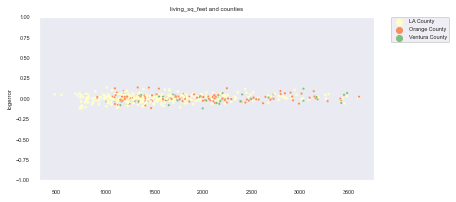

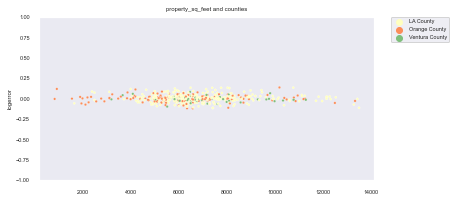

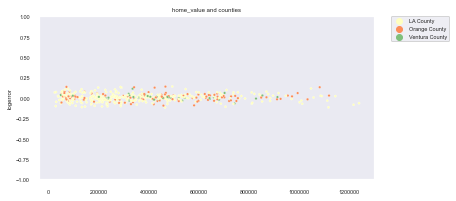

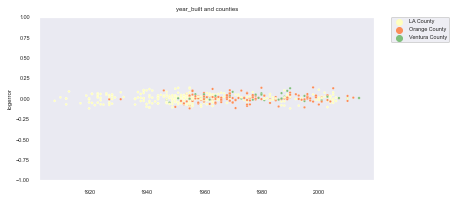

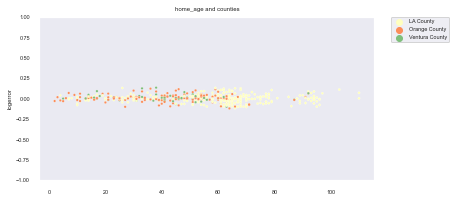

In [44]:
# viewing the log error relationship across continuous features, and counties



num_lst = [
'living_sq_feet',
'property_sq_feet',
'home_value',
'year_built',
'home_age']

for col in num_lst:
    plt.figure(figsize = (6,3))
    sns.set(style = "dark", font_scale = .5)
    ax = sns.scatterplot(x = col,
        y = "logerror",
        data = train_imputed.sample(500),
        hue = "county_by_fips",
        hue_order = ["LA County", "Orange County", "Ventura County"],
        palette = ["#ffffbf", "#fc8d59", "#7fbf7b"],
        sizes = (20,600),
        s = 6)
    
    # removing scientific notation
    ax.ticklabel_format(style = "plain")
    
    plt.title(f'{col} and counties')
    plt.ylim(-1, 1)
    plt.xlabel(None)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

    plt.show()

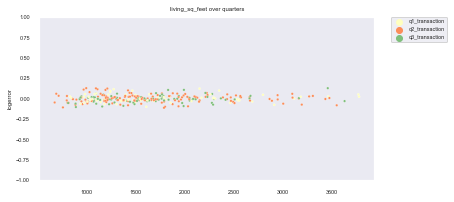

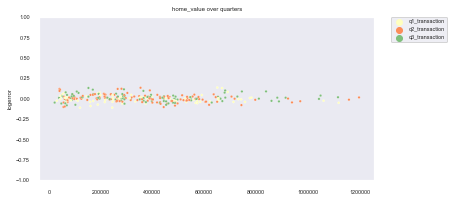

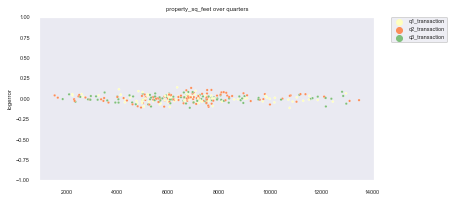

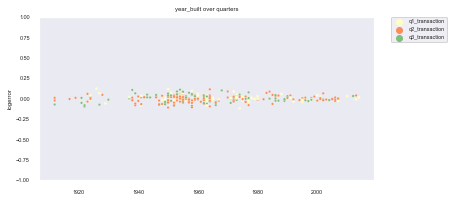

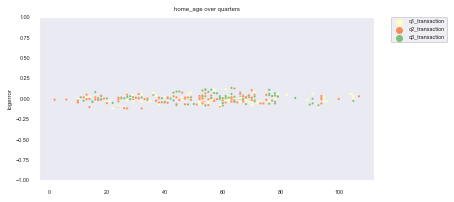

In [45]:
# viewing the log error relationship across continuous features, and transaction quarters

num_lst = [
 'living_sq_feet',
 'home_value',
 'property_sq_feet',
 'year_built',
 'home_age']

for col in num_lst:
    plt.figure(figsize = (6,3))
    sns.set(style = "dark", font_scale = .5)
    ax = sns.scatterplot(x = col,
        y = "logerror",
        data = train_imputed.sample(300),
        hue = "transaction_quarter",
        hue_order = ["q1_transaction", "q2_transaction", "q3_transaction"],
        palette = ["#ffffbf", "#fc8d59", "#7fbf7b"],
        sizes = (20,600),
        s = 6)

    # removing scientific notation
    ax.ticklabel_format(style = "plain")

    plt.title(f'{col} over quarters')
    plt.ylim(-1, 1)
    plt.xlabel(None)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    # plt.savefig(title, dpi=300)

    plt.show()

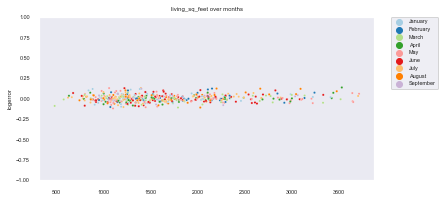

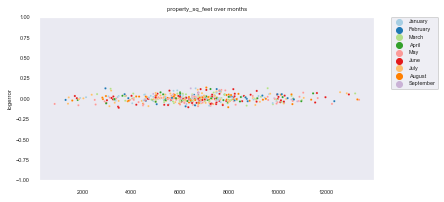

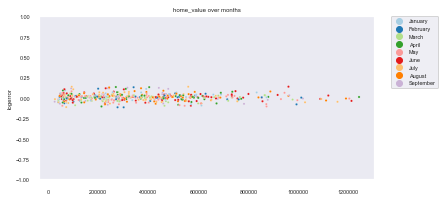

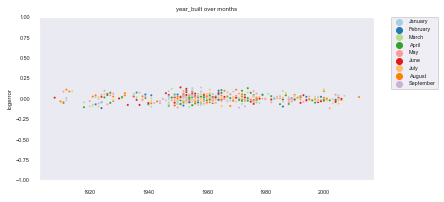

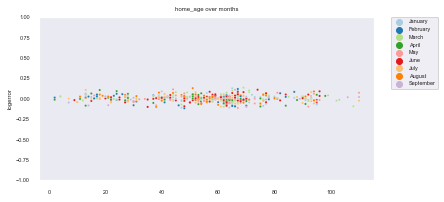

In [46]:
# viewing the log error relationship across continuous features, and transaction months

num_lst = [
    'living_sq_feet',
    'property_sq_feet',
    'home_value',
    'year_built',
    'home_age']

for col in num_lst:
    plt.figure(figsize = (6,3))
    sns.set(style = "dark", font_scale = .5)
    ax = sns.scatterplot(x = col,
        y = "logerror",
        data = train_imputed.sample(500),
        hue = "transaction_month",
        hue_order = [
            'January',
            'February',
            'March',
            'April',
            'May',
            'June',
            'July',
            'August',
            'September'],
        palette = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6'],
        sizes = (20,600),
        s = 5)
    
    # removing scientific notation
    ax.ticklabel_format(style = "plain") 
    

    plt.title(f'{col} over months')
    plt.ylim(-1, 1)
    plt.xlabel(None)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

    plt.show()

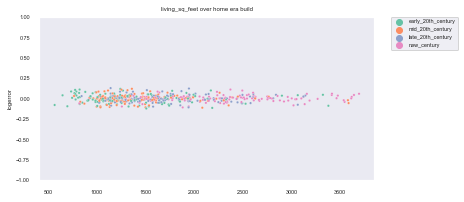

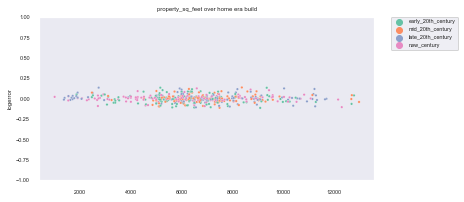

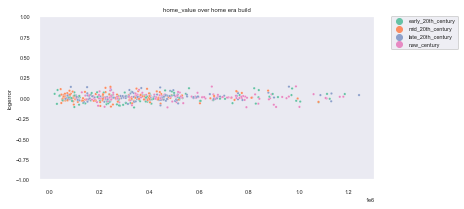

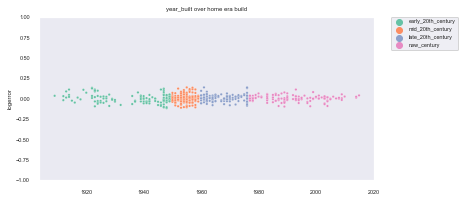

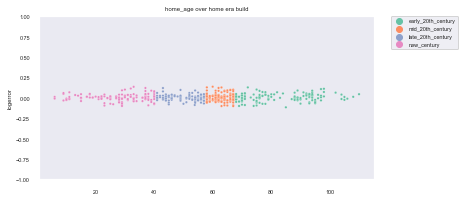

In [47]:
# viewing the log error relationship across continuous features, and home build era

num_lst = [
    'living_sq_feet',
    'property_sq_feet',
    'home_value',
    'year_built',
    'home_age']


for col in num_lst:
    plt.figure(figsize = (6,3))
    sns.set(style = "dark", font_scale = .5)
    sns.scatterplot(x = col,
        y = "logerror",
        data = train_imputed.sample(500),
        hue = "home_age_binned",
        hue_order = ['early_20th_century', 'mid_20th_century', 'late_20th_century', 'new_century'],
        palette = ['#66c2a5','#fc8d62','#8da0cb','#e78ac3'],
        sizes = (20,600),
        s = 6)

    plt.title(f'{col} over home era build')
    plt.ylim(-1, 1)
    plt.xlabel(None)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

    plt.show()

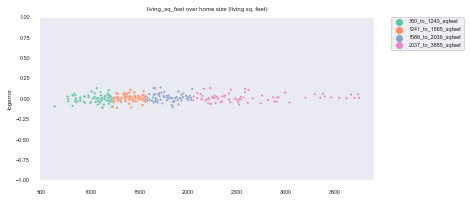

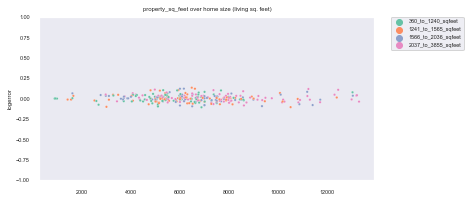

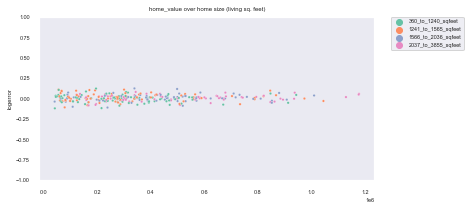

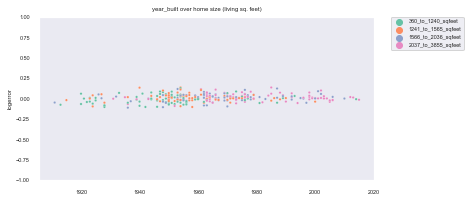

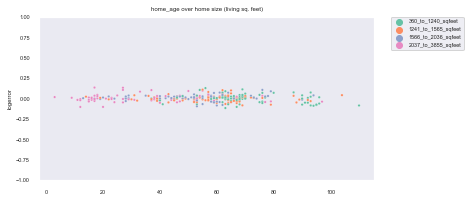

In [48]:
# viewing the log error relationship across continuous features, and home size (living sq. feet)

num_lst = [
    'living_sq_feet',
    'property_sq_feet',
    'home_value',
    'year_built',
    'home_age']

for col in num_lst:
    plt.figure(figsize = (6,3))
    sns.set(style = "dark", font_scale = .5)
    sns.scatterplot(x = col,
        y = "logerror",
        data = train_imputed.sample(300),
        hue = "living_sqfeet_binned",
        hue_order = ["360_to_1240_sqfeet", "1241_to_1565_sqfeet", "1566_to_2036_sqfeet", "2037_to_3855_sqfeet"],
        palette = ['#66c2a5','#fc8d62','#8da0cb','#e78ac3'],
        sizes = (20,600),
        s = 6)

    plt.title(f'{col} over home size (living sq. feet)')
    plt.ylim(-1, 1)
    plt.xlabel(None)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

    plt.show()

In [49]:
disc_values = list(train_imputed["transaction_quarter"].unique())
disc_values

['q3_transaction', 'q2_transaction', 'q1_transaction']

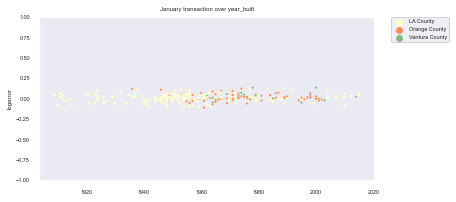

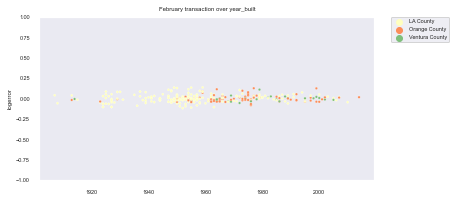

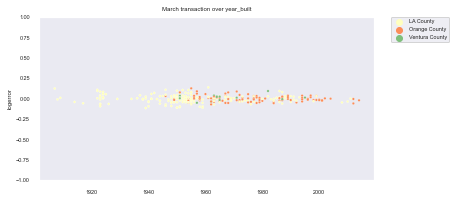

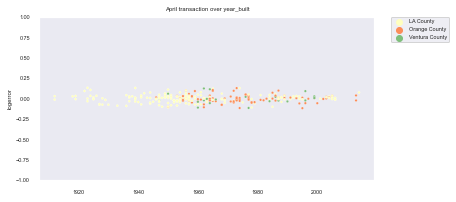

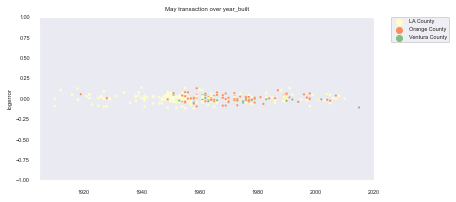

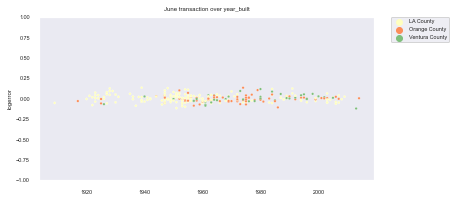

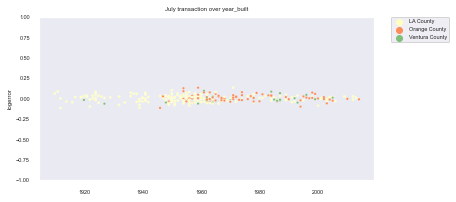

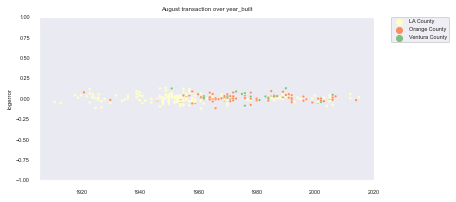

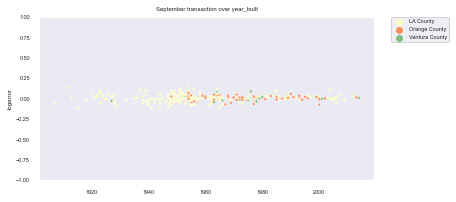

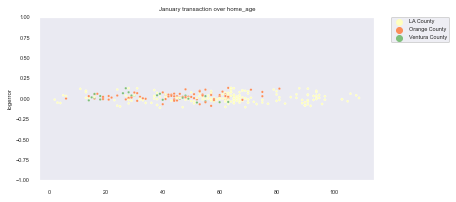

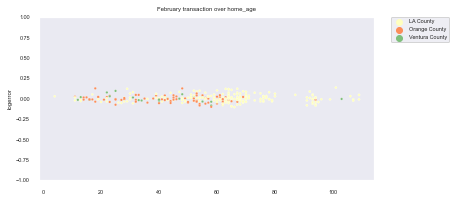

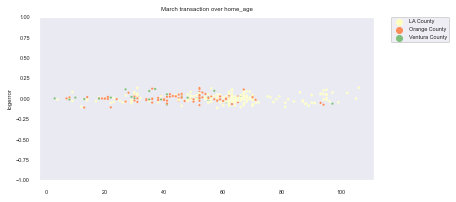

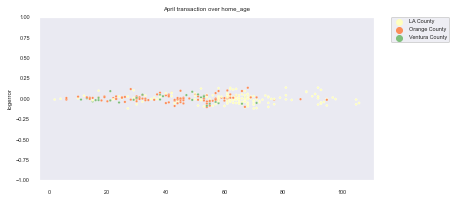

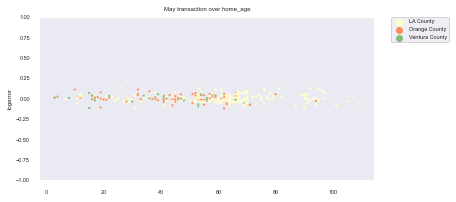

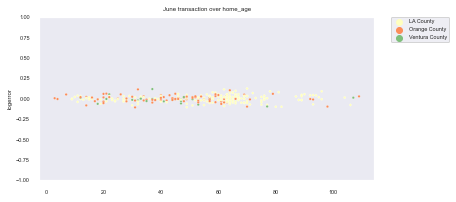

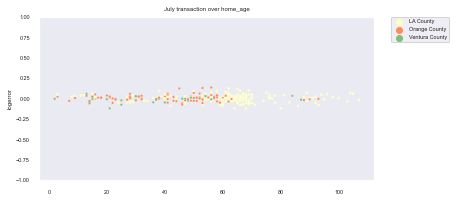

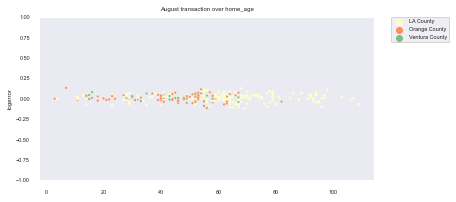

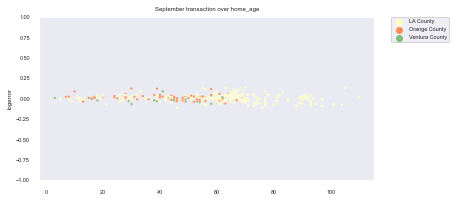

In [50]:
# example 1

num_lst = ['year_built', 'home_age']
disc_values = ['q1_transaction', 'q3_transaction', 'q2_transaction']

months_order = [
            'January',
            'February',
            'March',
            'April',
            'May',
            'June',
            'July',
            'August',
            'September']

for col in num_lst:
 
    for ele in months_order:

        plt.figure(figsize = (6,3))
        sns.set(style = "dark", font_scale = .5)

        df = train_imputed[train_imputed["transaction_month"] == ele]

        sns.scatterplot(x = col,
            y = "logerror",
            data = df.sample(300),
            hue = "county_by_fips",
            hue_order = ["LA County", "Orange County", "Ventura County"],
            palette = ["#ffffbf", "#fc8d59", "#7fbf7b"],
            sizes = (20,600),
            s = 6)

        plt.title(f'{ele} transaction over {col}')
        plt.ylim(-1, 1)
        plt.xlabel(None)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

        plt.show()

------
### ``Question #1: Is there a difference in log error across the three (3) counties?``

<u>**``Conducting ANOVA analysis across examined features``**</u>

**Null Hypothesis:** "There's **not** a statistical log error variance difference across features."

**Alternative Hypothesis:** "There **is** a statistical log error variance difference across features."

$\alpha$: 0.05

In [51]:
# setting the alpha value

confidence_interval = 0.95
alpha = 1 - confidence_interval

County: LA County
logerror: 0.0022660276650924406
-------------------------
County: Orange County
logerror: 0.0017563053599125341
-------------------------
County: Ventura County
logerror: 0.0016084499949349156
-------------------------


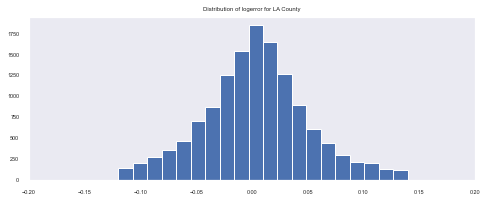

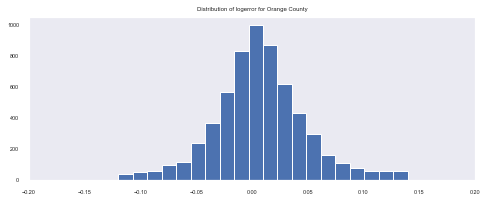

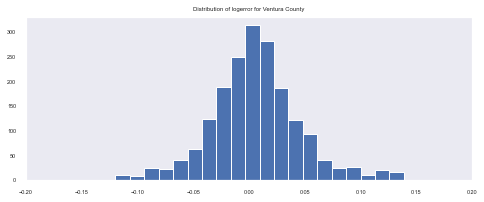

In [52]:
# Question Number #1:
# is there a difference in log error across the three (3) counties?

county_lst = list(train_imputed["county_by_fips"].unique())

for ele in county_lst:
    print(f'County: {ele}')
    print(f'logerror: {train_imputed[train_imputed["county_by_fips"] == ele].logerror.var()}')
    print('-------------------------')

    plt.figure(figsize = (8,3))
    plt.xlim(-.2, .2)

    plt.title('Distribution of logerror for {}'.format(ele))
    plt.hist(train_imputed[train_imputed["county_by_fips"] == ele].logerror, bins = 20)

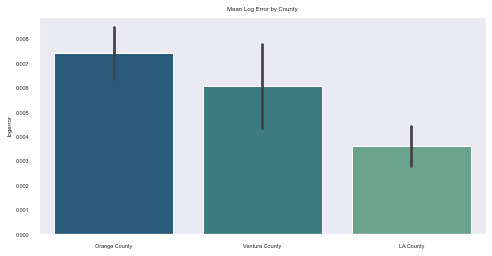

In [53]:
# average log error across counties

plt.figure(figsize = (8, 4))
sns.barplot(
    x = "county_by_fips", 
    y = "logerror", 
    data = train_imputed,
    order = ["Orange County", "Ventura County", "LA County"],
    palette = "crest_r")

plt.title("Mean Log Error by County")
plt.xlabel(None)
plt.show()

In [54]:
# conducting levene test to assess variance

#H0: Variances are equal
#Ha: Variances are not equal

l_stat, p_value = stats.levene(
    train_imputed[train_imputed["county_by_fips"] == "LA County"].logerror,
    train_imputed[train_imputed["county_by_fips"] == "Orange County"].logerror,
    train_imputed[train_imputed["county_by_fips"] == "Ventura County"].logerror)

# comparing the counties p_value to alpha
print(f'f statistic = {l_stat.round(5)}')
print(f'p value = {p_value.round(5)}')
print("-----------------")

if p_value < alpha:
    print('We reject the null hypothesis. Variances are not equal.')
else:
    print('We fail to reject the null hypothesis. Variances are relatively equal.')

f statistic = 97.58746
p value = 0.0
-----------------
We reject the null hypothesis. Variances are not equal.


In [55]:
# ANOVA hypothesis test

f_statistic, p_value = stats.f_oneway(
    train_imputed[train_imputed["county_by_fips"] == "LA County"].logerror,
    train_imputed[train_imputed["county_by_fips"] == "Orange County"].logerror,
    train_imputed[train_imputed["county_by_fips"] == "Ventura County"].logerror)


# comparing the counties p_value to alpha
print(f'f statistic = {f_statistic.round(5)}')
print(f'p value = {p_value.round(5)}')
print("-----------------")

if p_value < alpha:
    print('We reject the null hypothesis. Means are different across the groups.')
else:
    print('We fail to reject the null hypothesis. Means are similar across the groups.')

f statistic = 15.70497
p value = 0.0
-----------------
We reject the null hypothesis. Means are different across the groups.


------
### ``Question #2: Is there a difference in log error across home eras?``

**Null Hypothesis:** "There's **not** a statistical log error variance difference across features."

**Alternative Hypothesis:** "There **is** a statistical log error variance difference across features."

$\alpha$: 0.05

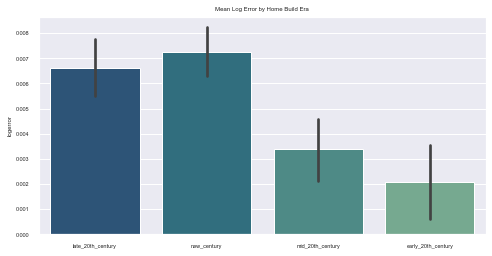

In [56]:
# average log error across home era

plt.figure(figsize = (8, 4))
sns.set(font_scale = 0.5)

sns.barplot(
    x = "home_age_binned", 
    y = "logerror", 
    data = train_imputed,
    order = ['late_20th_century', 'new_century', 'mid_20th_century', 'early_20th_century'],
    palette = "crest_r")

plt.title("Mean Log Error by Home Build Era")
plt.xlabel(None)
plt.show()

In [57]:
# conducting a lavene's test to assess variance

#H0: Variances are equal
#Ha: Variances are not equal

l_stat, p_value = stats.levene(
    train_imputed[train_imputed["home_age_binned"] == "new_century"].logerror,
    train_imputed[train_imputed["home_age_binned"] == "mid_20th_century"].logerror,
    train_imputed[train_imputed["home_age_binned"] == "early_20th_century"].logerror,
    train_imputed[train_imputed["home_age_binned"] == "late_20th_century"].logerror)

# comparing the counties p_value to alpha
print(f'f statistic = {l_stat.round(5)}')
print(f'p value = {p_value.round(5)}')
print("-----------------")

if p_value < alpha:
    print('We reject the null hypothesis. Variances are not equal.')
else:
    print('We fail to reject the null hypothesis. Variances are equal.')

f statistic = 187.15427
p value = 0.0
-----------------
We reject the null hypothesis. Variances are not equal.


In [58]:
# ANOVA hypothesis test for: home era

f_statistic, p_value = stats.f_oneway(
    train_imputed[train_imputed["home_age_binned"] == "new_century"].logerror,
    train_imputed[train_imputed["home_age_binned"] == "late_20th_century"].logerror,
    train_imputed[train_imputed["home_age_binned"] == "mid_20th_century"].logerror,
    train_imputed[train_imputed["home_age_binned"] == "early_20th_century"].logerror)


# comparing the counties p_value to alpha
print(f'f statistic = {f_statistic.round(5)}')
print(f'p value = {p_value.round(5)}')
print("-----------------")

if p_value < alpha:
    print('We reject the null hypothesis. Means are different across the groups.')
else:
    print('We fail to reject the null hypothesis. Means are similar across the groups.')

f statistic = 15.70254
p value = 0.0
-----------------
We reject the null hypothesis. Means are different across the groups.


----
### ``Question #3: Is there a difference in log error across home era in Orange County?``

**Null Hypothesis:** There's not a logerror variance difference across home eras in Orange County.

**Althernative Hypothesis:** There is a logerror variance difference across home eras in Orange County.

In [59]:
# setting the alpha value

alpha = 0.05

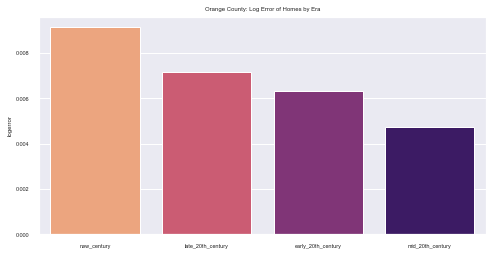

In [60]:
# is there a difference in logerror across orange county and the home build era?

county_lst = list(train_imputed["county_by_fips"].unique())
home_era = list(train_imputed["home_age_binned"].unique())

plt.figure(figsize = (8, 4))
sns.barplot(
    x = "home_age_binned",
    y = train_imputed[train_imputed["county_by_fips"] == "Orange County"].logerror,
    data = train_imputed,
    order = ["new_century", "late_20th_century", "early_20th_century", "mid_20th_century"], 
    ci = None,
    palette = "magma_r")

plt.title("Orange County: Log Error of Homes by Era")
plt.xlabel(None)
plt.show()

In [61]:
# conducting levene test to assess variance across build era and orange county

#H0: Variances are equal
#Ha: Variances are not equal

l_stat, p_value = stats.levene(
    train_imputed[(train_imputed["home_age_binned"] == "new_century") & (train_imputed["county_by_fips"] == "Orange County")].logerror,
    train_imputed[(train_imputed["home_age_binned"] == "mid_20th_century") & (train_imputed["county_by_fips"] == "Orange County")].logerror,
    train_imputed[(train_imputed["home_age_binned"] == "early_20th_century") & (train_imputed["county_by_fips"] == "Orange County")].logerror,
    train_imputed[(train_imputed["home_age_binned"] == "late_20th_century") & (train_imputed["county_by_fips"] == "Orange County")].logerror)

# comparing the counties p_value to alpha
print(f'f statistic = {l_stat.round(5)}')
print(f'p value = {p_value.round(5)}')
print("-----------------")

if p_value < alpha:
    print('We reject the null hypothesis. Variances are not equal.')
else:
    print('We fail to reject the null hypothesis. Variances are relatively equal.')

f statistic = 33.47025
p value = 0.0
-----------------
We reject the null hypothesis. Variances are not equal.


In [62]:
# ANOVA hypothesis test for: home era

f_statistic, p_value = stats.f_oneway(
    train_imputed[(train_imputed["home_age_binned"] == "new_century") & (train_imputed["county_by_fips"] == "Orange County")].logerror,
    train_imputed[(train_imputed["home_age_binned"] == "mid_20th_century") & (train_imputed["county_by_fips"] == "Orange County")].logerror,
    train_imputed[(train_imputed["home_age_binned"] == "early_20th_century") & (train_imputed["county_by_fips"] == "Orange County")].logerror,
    train_imputed[(train_imputed["home_age_binned"] == "late_20th_century") & (train_imputed["county_by_fips"] == "Orange County")].logerror)

# comparing the counties p_value to alpha
print(f'f statistic = {f_statistic.round(5)}')
print(f'p value = {p_value.round(5)}')
print("-----------------")

if p_value < alpha:
    print('We reject the null hypothesis. Means are different across the groups.')
else:
    print('We fail to reject the null hypothesis. Means are similar across the groups.')

f statistic = 2.86852
p value = 0.03511
-----------------
We reject the null hypothesis. Means are different across the groups.


----
### ``Question #4: Is there a difference in log error across transaction quarter?``

**Null Hypothesis:** "There's **not** a statistical log error variance difference across features."

**Alternative Hypothesis:** "There **is** a statistical log error variance difference across features."

$\alpha$: 0.05

In [63]:
# setting the alpha value

alpha = 0.05

In [64]:
# checking the dataframe

train_imputed.head()

parcel_id  home_value  logerror  bathroom_count  bedroom_count  \
49143  11279487    74239.00     -0.02            1.00           3.00   
18505  14235131   426984.00     -0.02            2.50           3.00   
1594   12461319   399808.00      0.02            2.00           3.00   
35506  14139772    71763.00     -0.06            2.00           3.00   
11229  14491761   354226.00     -0.03            1.00           2.00   

       living_sq_feet county_by_fips    latitude     longitude  \
49143          943.00      LA County 34695455.00 -118167705.00   
18505         1436.00  Orange County 33794700.00 -117823000.00   
1594          1470.00      LA County 33843316.00 -118173744.00   
35506         1403.00  Orange County 33905449.00 -117892188.00   
11229          936.00  Orange County 33625277.00 -117662397.00   

       property_sq_feet county_zoning_code  blockgroup_assignment  year_built  \
49143           7834.00               0100            60379010.08     1955.00   
18505           2490.00                122            60590758.15     1989.00   
1594            6336.00               0100            60375715.03     1942.00   
35506           7770.00                122            60590015.05     1963.00   
11229           5000.00                122            60590320.28     1972.00   

       home_age transaction_month     home_age_binned living_sqfeet_binned  \
49143     62.00         September    mid_20th_century   360_to_1240_sqfeet   
18505     28.00             April         new_century  1241_to_1565_sqfeet   
1594      75.00           January  early_20th_century  1241_to_1565_sqfeet   
35506     54.00              June   late_20th_century  1241_to_1565_sqfeet   
11229     45.00             March   late_20th_century   360_to_1240_sqfeet   

      transaction_quarter  
49143      q3_transaction  
18505      q2_transaction  
1594       q1_transaction  
35506      q2_transaction  
11229      q1_transaction

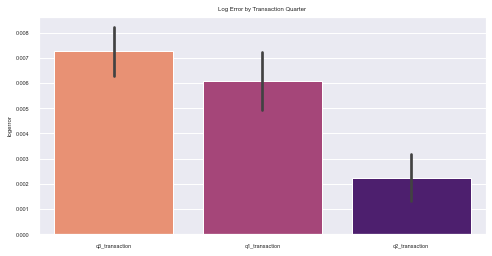

In [65]:
# plotting home transactions by quarters

plt.figure(figsize = (8, 4))
sns.set(font_scale = 0.5)
plt.xlabel(None)

sns.barplot(
    x = "transaction_quarter",
    y = "logerror",
    data = train_imputed,
    order = ["q3_transaction", "q1_transaction", "q2_transaction"], 
    palette = "magma_r")

plt.title("Log Error by Transaction Quarter")
plt.xlabel(None)
plt.show()

In [66]:
# conducting levene test to assess variance

#H0: Variances are equal
#Ha: Variances are not equal

l_stat, p_value = stats.levene(
    train_imputed[train_imputed["transaction_quarter"] == "q1_transaction"].logerror,
    train_imputed[train_imputed["transaction_quarter"] == "q2_transaction"].logerror,
    train_imputed[train_imputed["transaction_quarter"] == "q3_transaction"].logerror)

# comparing the counties p_value to alpha
print(f'f statistic = {l_stat.round(5)}')
print(f'p value = {p_value.round(5)}')
print("-----------------")

if p_value < alpha:
    print('We reject the null hypothesis. Variances are not equal.')
else:
    print('We fail to reject the null hypothesis. Variances are relatively equal.')

f statistic = 3.7307
p value = 0.02399
-----------------
We reject the null hypothesis. Variances are not equal.


In [67]:
# ANOVA hypothesis test for: transactions by quarter

f_statistic, p_value = stats.f_oneway(
    train_imputed[train_imputed["transaction_quarter"] == "q1_transaction"].logerror,
    train_imputed[train_imputed["transaction_quarter"] == "q2_transaction"].logerror,
    train_imputed[train_imputed["transaction_quarter"] == "q3_transaction"].logerror)

# comparing the counties p_value to alpha
print(f'f statistic = {f_statistic.round(5)}')
print(f'p value = {p_value.round(5)}')
print("-----------------")

if p_value < alpha:
    print('We reject the null hypothesis. Means are different across the groups.')
else:
    print('We fail to reject the null hypothesis. Means are similar across the groups.')

f statistic = 26.55025
p value = 0.0
-----------------
We reject the null hypothesis. Means are different across the groups.


----
### ``Question #5: Is there a difference in log error across transaction month?``

**Null Hypothesis:** "There's **not** an average statistical logerror  difference across features."

**Alternative Hypothesis:** "There **is** an average statistical logerror  difference across features."

$\alpha$: 0.05 

In [68]:
# let's get a list of all the months

lst_of_months = list(train["transaction_month"].unique())
lst_of_months # checks out!

['September',
 'April',
 'January',
 'June',
 'March',
 'August',
 'May',
 'February',
 'July']

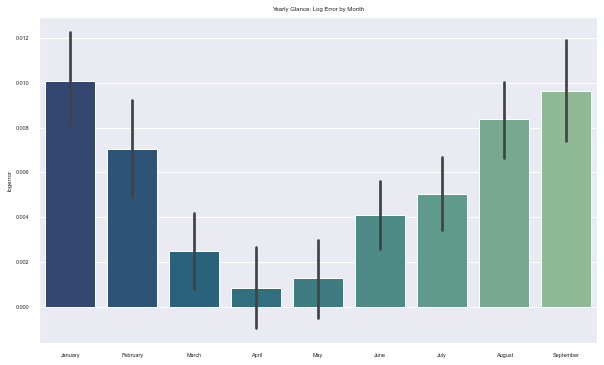

In [69]:
# plotting log error for all months

plt.figure(figsize = (10, 6))
sns.barplot(x = "transaction_month",
    y = "logerror", 
    data = train_imputed,
    order = [
    'January',
    'February',
    'March',
    'April',
    'May',
    'June',
    'July',
    'August',
    'September'],
    palette = "crest_r",
    ci = 95)

plt.title("Yearly Glance: Log Error by Month")
plt.xlabel(None)
plt.show()

In [70]:
# conducting levene test to assess variance

#H0: Variances are equal
#Ha: Variances are not equal

l_stat, p_value = stats.levene(
    train_imputed[train_imputed["transaction_month"] == "January"].logerror,
    train_imputed[train_imputed["transaction_month"] == "February"].logerror,
    train_imputed[train_imputed["transaction_month"] == "March"].logerror,
    train_imputed[train_imputed["transaction_month"] == "April"].logerror,
    train_imputed[train_imputed["transaction_month"] == "May"].logerror,
    train_imputed[train_imputed["transaction_month"] == "June"].logerror,
    train_imputed[train_imputed["transaction_month"] == "July"].logerror,
    train_imputed[train_imputed["transaction_month"] == "August"].logerror,
    train_imputed[train_imputed["transaction_month"] == "September"].logerror)

# comparing the counties p_value to alpha
print(f'f statistic = {l_stat.round(5)}')
print(f'p value = {p_value.round(5)}')
print("-----------------")

if p_value < alpha:
    print('We reject the null hypothesis. Variances are not equal.')
else:
    print('We fail to reject the null hypothesis. Variances are relatively equal.')

f statistic = 1.71172
p value = 0.09017
-----------------
We fail to reject the null hypothesis. Variances are relatively equal.


In [71]:
# ANOVA hypothesis test for: transactions by quarter

f_statistic, p_value = stats.f_oneway(
    train_imputed[train_imputed["transaction_month"] == "January"].logerror,
    train_imputed[train_imputed["transaction_month"] == "February"].logerror,
    train_imputed[train_imputed["transaction_month"] == "March"].logerror,
    train_imputed[train_imputed["transaction_month"] == "April"].logerror,
    train_imputed[train_imputed["transaction_month"] == "May"].logerror,
    train_imputed[train_imputed["transaction_month"] == "June"].logerror,
    train_imputed[train_imputed["transaction_month"] == "July"].logerror,
    train_imputed[train_imputed["transaction_month"] == "August"].logerror,
    train_imputed[train_imputed["transaction_month"] == "September"].logerror)

# comparing the counties p_value to alpha
print(f'f statistic = {f_statistic.round(5)}')
print(f'p value = {p_value.round(5)}')
print("-----------------")

if p_value < alpha:
    print('We reject the null hypothesis. Means are different across the groups.')
else:
    print('We fail to reject the null hypothesis. Means are similar across the groups.')

f statistic = 13.19602
p value = 0.0
-----------------
We reject the null hypothesis. Means are different across the groups.


----
### ``Question #6: Is there a difference across home transaction months in Orange County?``

**Null Hypothesis:** There's not a logerror variance difference across transaction months in Orange County.

**Althernative Hypothesis:** There is a logerror variance difference across transaction months in Orange County.

$\alpha$: 0.05

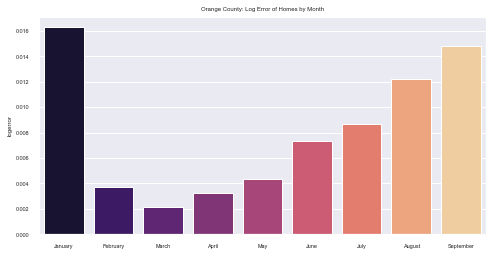

In [72]:
county_lst = list(train_imputed["county_by_fips"].unique())
home_era = list(train_imputed["home_age_binned"].unique())

plt.figure(figsize = (8, 4))
sns.barplot(
    x = "transaction_month",
    y = train_imputed[train_imputed["county_by_fips"] == "Orange County"].logerror,
    data = train_imputed, 
    ci = None,
    order = [
    'January',
    'February',
    'March',
    'April',
    'May',
    'June',
    'July',
    'August',
    'September'],
    palette = "magma")

plt.title("Orange County: Log Error of Homes by Month")
plt.xlabel(None)
plt.show()

In [73]:
# conducting levene test to assess variance

#H0: Variances are equal
#Ha: Variances are not equal

l_stat, p_value = stats.levene(
    train_imputed[(train_imputed["transaction_month"] == "January") & (train_imputed["county_by_fips"] == "Orange County")].logerror,
    train_imputed[(train_imputed["transaction_month"] == "February") & (train_imputed["county_by_fips"] == "Orange County")].logerror,
    train_imputed[(train_imputed["transaction_month"] == "March")& (train_imputed["county_by_fips"] == "Orange County")].logerror,
    train_imputed[(train_imputed["transaction_month"] == "April") & (train_imputed["county_by_fips"] == "Orange County")].logerror,
    train_imputed[(train_imputed["transaction_month"] == "May") & (train_imputed["county_by_fips"] == "Orange County")].logerror,
    train_imputed[(train_imputed["transaction_month"] == "June") & (train_imputed["county_by_fips"] == "Orange County")].logerror,
    train_imputed[(train_imputed["transaction_month"] == "July") & (train_imputed["county_by_fips"] == "Orange County")].logerror,
    train_imputed[(train_imputed["transaction_month"] == "August") & (train_imputed["county_by_fips"] == "Orange County")].logerror,
    train_imputed[(train_imputed["transaction_month"] == "September") & (train_imputed["county_by_fips"] == "Orange County")].logerror)

# comparing the counties p_value to alpha
print(f'f statistic = {l_stat.round(5)}')
print(f'p value = {p_value.round(5)}')
print("-----------------")

if p_value < alpha:
    print('We reject the null hypothesis. Variances are not equal.')
else:
    print('We fail to reject the null hypothesis. Variances are relatively equal.')

f statistic = 2.08883
p value = 0.03343
-----------------
We reject the null hypothesis. Variances are not equal.


In [74]:
# ANOVA hypothesis test for: transactions by quarter in Orange County

f_statistic, p_value = stats.f_oneway(
   train_imputed[(train_imputed["transaction_month"] == "January") & (train_imputed["county_by_fips"] == "Orange County")].logerror,
    train_imputed[(train_imputed["transaction_month"] == "February") & (train_imputed["county_by_fips"] == "Orange County")].logerror,
    train_imputed[(train_imputed["transaction_month"] == "March")& (train_imputed["county_by_fips"] == "Orange County")].logerror,
    train_imputed[(train_imputed["transaction_month"] == "April") & (train_imputed["county_by_fips"] == "Orange County")].logerror,
    train_imputed[(train_imputed["transaction_month"] == "May") & (train_imputed["county_by_fips"] == "Orange County")].logerror,
    train_imputed[(train_imputed["transaction_month"] == "June") & (train_imputed["county_by_fips"] == "Orange County")].logerror,
    train_imputed[(train_imputed["transaction_month"] == "July") & (train_imputed["county_by_fips"] == "Orange County")].logerror,
    train_imputed[(train_imputed["transaction_month"] == "August") & (train_imputed["county_by_fips"] == "Orange County")].logerror,
    train_imputed[(train_imputed["transaction_month"] == "September") & (train_imputed["county_by_fips"] == "Orange County")].logerror)

# comparing the counties p_value to alpha
print(f'f statistic = {f_statistic.round(5)}')
print(f'p value = {p_value.round(5)}')
print("-----------------")

if p_value < alpha:
    print('We reject the null hypothesis. Means are different across the groups.')
else:
    print('We fail to reject the null hypothesis. Means are similar across the groups.')

f statistic = 8.8818
p value = 0.0
-----------------
We reject the null hypothesis. Means are different across the groups.


----
### ``Question #7: Is there a difference in log error across grouped home sizes (binned sq-feet)?``

**Null Hypothesis:** There's not a logerror variance difference across group home sizes.

**Althernative Hypothesis:** There is a logerror variance difference across group home sizes.

$\alpha$: 0.05

In [75]:
size_lst = list(train_imputed["living_sqfeet_binned"].unique().sort_values())
size_lst

['360_to_1240_sqfeet',
 '1241_to_1565_sqfeet',
 '1566_to_2036_sqfeet',
 '2037_to_3855_sqfeet']

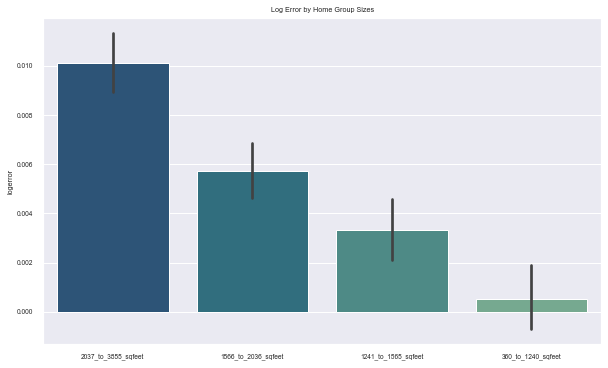

In [76]:
# creating a for loop to bar plot log error for all months

plt.figure(figsize = (10, 6))
sns.set(font_scale = 0.6)
sns.barplot(x = "living_sqfeet_binned",
    y = "logerror", 
    data = train_imputed,
    order = [
        "2037_to_3855_sqfeet", 
        "1566_to_2036_sqfeet", 
        "1241_to_1565_sqfeet",
        "360_to_1240_sqfeet"],
    palette = "crest_r",
    ci = 95)

plt.title("Log Error by Home Group Sizes")
plt.xlabel(None)
plt.show()

In [77]:
# conducting levene test to assess variance

#H0: Variances are equal
#Ha: Variances are not equal

l_stat, p_value = stats.levene(
    train_imputed[train_imputed["living_sqfeet_binned"] == "360_to_1240_sqfeet"].logerror,
    train_imputed[train_imputed["living_sqfeet_binned"] == "1241_to_1565_sqfeet"].logerror,
    train_imputed[train_imputed["living_sqfeet_binned"] == "1566_to_2036_sqfeet"].logerror,
    train_imputed[train_imputed["living_sqfeet_binned"] == "2037_to_3855_sqfeet"].logerror)


# comparing the counties p_value to alpha
print(f'f statistic = {l_stat.round(5)}')
print(f'p value = {p_value.round(5)}')
print("-----------------")

if p_value < alpha:
    print('We reject the null hypothesis. Variances are not equal.')
else:
    print('We fail to reject the null hypothesis. Variances are relatively equal.')

f statistic = 36.4482
p value = 0.0
-----------------
We reject the null hypothesis. Variances are not equal.


In [78]:
# ANOVA hypothesis test for: home size groups

f_statistic, p_value = stats.f_oneway(
    train_imputed[train_imputed["living_sqfeet_binned"] == "360_to_1240_sqfeet"].logerror,
    train_imputed[train_imputed["living_sqfeet_binned"] == "1241_to_1565_sqfeet"].logerror,
    train_imputed[train_imputed["living_sqfeet_binned"] == "1566_to_2036_sqfeet"].logerror,
    train_imputed[train_imputed["living_sqfeet_binned"] == "2037_to_3855_sqfeet"].logerror)

# comparing the counties p_value to alpha
print(f'f statistic = {f_statistic.round(5)}')
print(f'p value = {p_value.round(5)}')
print("-----------------")

if p_value < alpha:
    print('We reject the null hypothesis. Means are different across the groups.')
else:
    print('We fail to reject the null hypothesis. Means are similar across the groups.')

f statistic = 43.50843
p value = 0.0
-----------------
We reject the null hypothesis. Means are different across the groups.


----
### ``Hypothesis Testing on Independent Features:``

In [79]:
# checking the df head 

train_imputed.head()

parcel_id  home_value  logerror  bathroom_count  bedroom_count  \
49143  11279487    74239.00     -0.02            1.00           3.00   
18505  14235131   426984.00     -0.02            2.50           3.00   
1594   12461319   399808.00      0.02            2.00           3.00   
35506  14139772    71763.00     -0.06            2.00           3.00   
11229  14491761   354226.00     -0.03            1.00           2.00   

       living_sq_feet county_by_fips    latitude     longitude  \
49143          943.00      LA County 34695455.00 -118167705.00   
18505         1436.00  Orange County 33794700.00 -117823000.00   
1594          1470.00      LA County 33843316.00 -118173744.00   
35506         1403.00  Orange County 33905449.00 -117892188.00   
11229          936.00  Orange County 33625277.00 -117662397.00   

       property_sq_feet county_zoning_code  blockgroup_assignment  year_built  \
49143           7834.00               0100            60379010.08     1955.00   
18505           2490.00                122            60590758.15     1989.00   
1594            6336.00               0100            60375715.03     1942.00   
35506           7770.00                122            60590015.05     1963.00   
11229           5000.00                122            60590320.28     1972.00   

       home_age transaction_month     home_age_binned living_sqfeet_binned  \
49143     62.00         September    mid_20th_century   360_to_1240_sqfeet   
18505     28.00             April         new_century  1241_to_1565_sqfeet   
1594      75.00           January  early_20th_century  1241_to_1565_sqfeet   
35506     54.00              June   late_20th_century  1241_to_1565_sqfeet   
11229     45.00             March   late_20th_century   360_to_1240_sqfeet   

      transaction_quarter  
49143      q3_transaction  
18505      q2_transaction  
1594       q1_transaction  
35506      q2_transaction  
11229      q1_transaction

In [80]:
col_lst = train_imputed.columns.tolist()
col_lst

['parcel_id',
 'home_value',
 'logerror',
 'bathroom_count',
 'bedroom_count',
 'living_sq_feet',
 'county_by_fips',
 'latitude',
 'longitude',
 'property_sq_feet',
 'county_zoning_code',
 'blockgroup_assignment',
 'year_built',
 'home_age',
 'transaction_month',
 'home_age_binned',
 'living_sqfeet_binned',
 'transaction_quarter']

In [81]:
# let's generate dummy variables for the following and scale our data

# transaction month
# home age binned
# living sq feet binned
# transaction quarters

# train dataset
train_dummy = pd.get_dummies(data = train_imputed, columns = [
    'transaction_month', 
    'home_age_binned',
    'bathroom_count',
    'bedroom_count',
    'county_by_fips',
    'living_sqfeet_binned',
    'transaction_quarter'],
    drop_first = False, 
    dtype = bool)

# validate dataset
validate_dummy = pd.get_dummies(data = validate_imputed, columns = [
    'transaction_month', 
    'home_age_binned',
    'bathroom_count',
    'bedroom_count',
    'county_by_fips',
    'living_sqfeet_binned',
    'transaction_quarter'],
    drop_first = False, 
    dtype = bool)

# test dataset
test_dummy = pd.get_dummies(data = test_imputed, columns = [
    'transaction_month', 
    'home_age_binned',
    'bathroom_count',
    'bedroom_count',
    'county_by_fips',
    'living_sqfeet_binned',
    'transaction_quarter'],
    drop_first = False, 
    dtype = bool)

# checking the train dataset
train_dummy.head()

parcel_id  home_value  logerror  living_sq_feet    latitude  \
49143  11279487    74239.00     -0.02          943.00 34695455.00   
18505  14235131   426984.00     -0.02         1436.00 33794700.00   
1594   12461319   399808.00      0.02         1470.00 33843316.00   
35506  14139772    71763.00     -0.06         1403.00 33905449.00   
11229  14491761   354226.00     -0.03          936.00 33625277.00   

          longitude  property_sq_feet county_zoning_code  \
49143 -118167705.00           7834.00               0100   
18505 -117823000.00           2490.00                122   
1594  -118173744.00           6336.00               0100   
35506 -117892188.00           7770.00                122   
11229 -117662397.00           5000.00                122   

       blockgroup_assignment  year_built  ...  county_by_fips_LA County  \
49143            60379010.08     1955.00  ...                      True   
18505            60590758.15     1989.00  ...                     False   
1594             60375715.03     1942.00  ...                      True   
35506            60590015.05     1963.00  ...                     False   
11229            60590320.28     1972.00  ...                     False   

       county_by_fips_Orange County  county_by_fips_Ventura County  \
49143                         False                          False   
18505                          True                          False   
1594                          False                          False   
35506                          True                          False   
11229                          True                          False   

       living_sqfeet_binned_360_to_1240_sqfeet  \
49143                                     True   
18505                                    False   
1594                                     False   
35506                                    False   
11229                                     True   

       living_sqfeet_binned_1241_to_1565_sqfeet  \
49143                                     False   
18505                                      True   
1594                                       True   
35506                                      True   
11229                                     False   

       living_sqfeet_binned_1566_to_2036_sqfeet  \
49143                                     False   
18505                                     False   
1594                                      False   
35506                                     False   
11229                                     False   

       living_sqfeet_binned_2037_to_3855_sqfeet  \
49143                                     False   
18505                                     False   
1594                                      False   
35506                                     False   
11229                                     False   

       transaction_quarter_q1_transaction  transaction_quarter_q2_transaction  \
49143                               False                               False   
18505                               False                                True   
1594                                 True                               False   
35506                               False                                True   
11229                                True                               False   

       transaction_quarter_q3_transaction  
49143                                True  
18505                               False  
1594                                False  
35506                               False  
11229                               False  

[5 rows x 47 columns]

In [82]:
#column dtypes

train_dummy.dtypes.sort_values(ascending = False)

parcel_id                                    object
county_zoning_code                           object
property_sq_feet                            float64
home_value                                  float64
home_age                                    float64
blockgroup_assignment                       float64
year_built                                  float64
longitude                                   float64
latitude                                    float64
living_sq_feet                              float64
logerror                                    float64
county_by_fips_LA County                       bool
bathroom_count_4.5                             bool
bedroom_count_1.0                              bool
bedroom_count_2.0                              bool
bedroom_count_3.0                              bool
bedroom_count_4.0                              bool
bedroom_count_5.0                              bool
living_sqfeet_binned_1566_to_2036_sqfeet       bool
county_by_fi

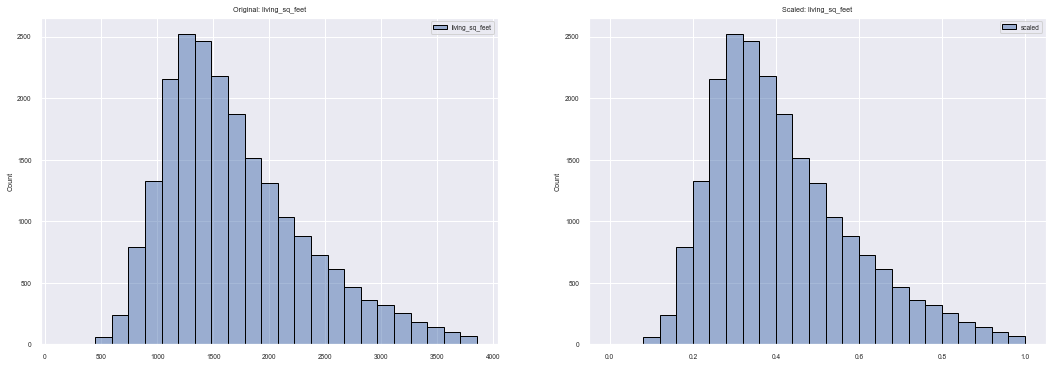

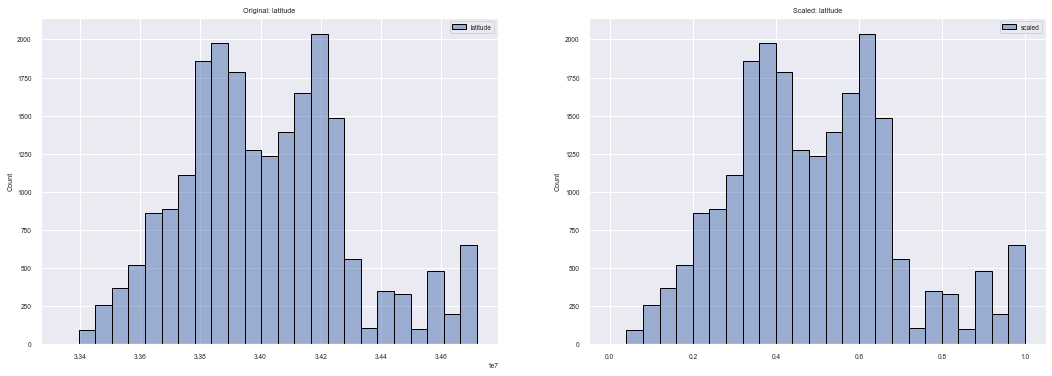

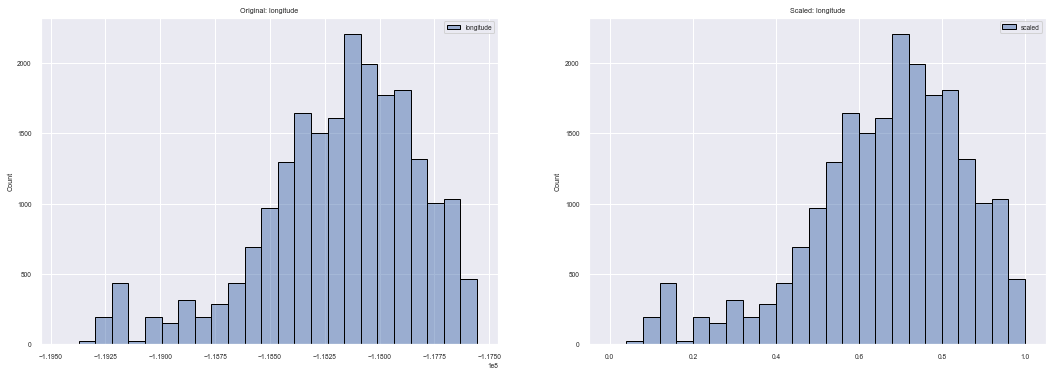

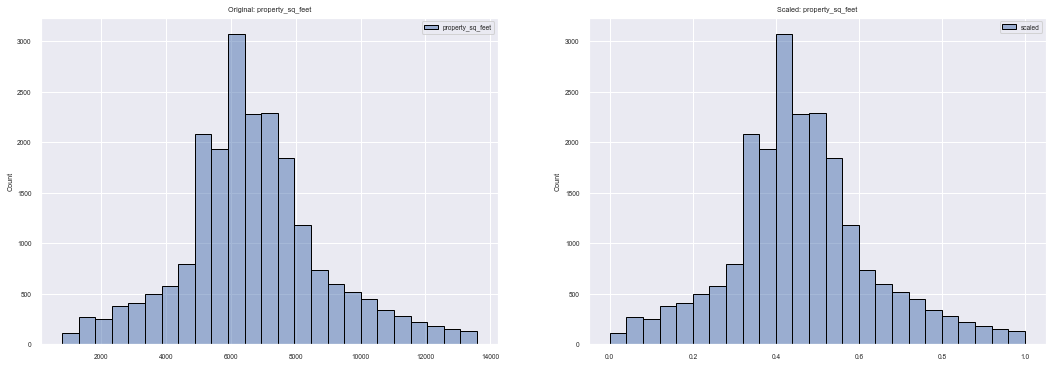

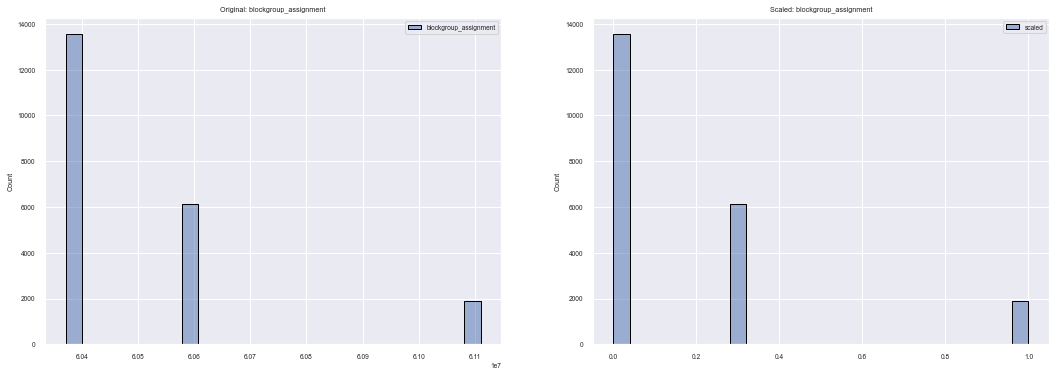

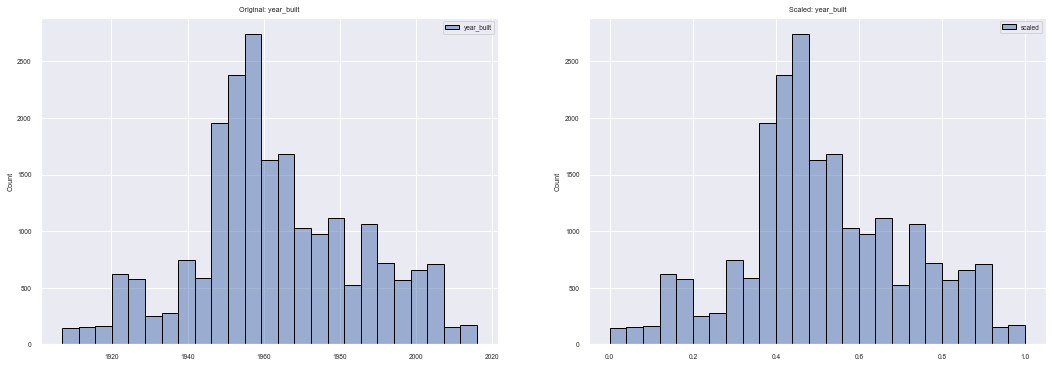

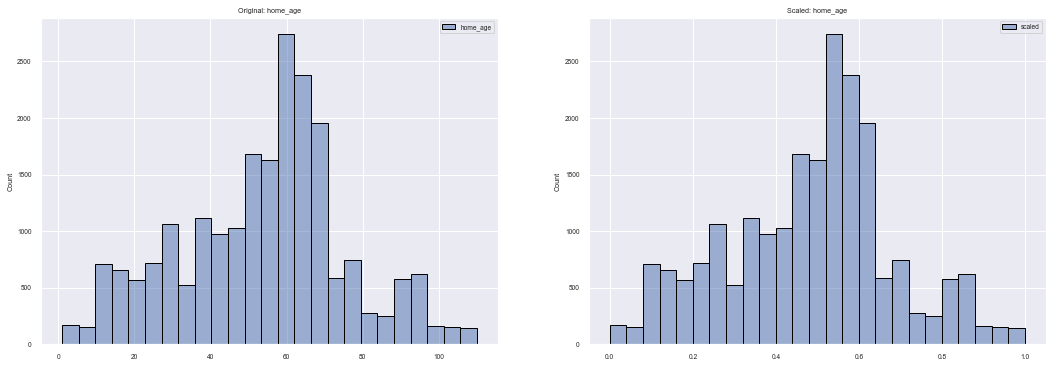

In [83]:
cont_lst = train_dummy.select_dtypes(exclude = ["object", "category", "uint8", "int64", "bool"]).columns.tolist()
cont_lst = [ele for ele in cont_lst if ele not in ("logerror", "home_value")]

for col in cont_lst:
    scaler = MinMaxScaler()
    scaler.fit(train_dummy[[col]])

    x_scaled = scaler.transform(train_dummy[[col]])

    plt.figure(figsize=(18, 6))
    plt.subplot(121)
    sns.histplot(train_dummy[[col]], bins = 25, edgecolor = 'black', label = col)
    
    plt.title(f'Original: {col}')
    plt.legend()

    plt.subplot(122)
    ax = sns.histplot(x_scaled, bins=25, edgecolor = 'black', label = "scaled")
    
    # removing axes scientific notation 
    ax.ticklabel_format(style = "plain") 
    plt.title(f'Scaled: {col}')
    plt.legend()

In [84]:
# scaling necessary features in datasets

scaler = MinMaxScaler()
scaler.fit(train_dummy[cont_lst])

# dummy datasets
train_dummy[cont_lst] = scaler.transform(train_dummy[cont_lst])
validate_dummy[cont_lst] = scaler.transform(validate_dummy[cont_lst])
test_dummy[cont_lst] = scaler.transform(test_dummy[cont_lst])

# non-dummy datasets
train_imputed[cont_lst] = scaler.transform(train_imputed[cont_lst])
validate_imputed[cont_lst] = scaler.transform(validate_imputed[cont_lst])
test_imputed[cont_lst] = scaler.transform(test_imputed[cont_lst])

In [85]:
# let's check the scaler worked

train_dummy.head() # checks out!

parcel_id  home_value  logerror  living_sq_feet  latitude  longitude  \
49143  11279487    74239.00     -0.02            0.21      0.98       0.68   
18505  14235131   426984.00     -0.02            0.35      0.33       0.86   
1594   12461319   399808.00      0.02            0.36      0.36       0.67   
35506  14139772    71763.00     -0.06            0.34      0.41       0.82   
11229  14491761   354226.00     -0.03            0.21      0.21       0.94   

       property_sq_feet county_zoning_code  blockgroup_assignment  year_built  \
49143              0.55               0100                   0.01        0.44   
18505              0.13                122                   0.30        0.75   
1594               0.43               0100                   0.01        0.32   
35506              0.55                122                   0.30        0.51   
11229              0.33                122                   0.30        0.60   

       ...  county_by_fips_LA County  county_by_fips_Orange County  \
49143  ...                      True                         False   
18505  ...                     False                          True   
1594   ...                      True                         False   
35506  ...                     False                          True   
11229  ...                     False                          True   

       county_by_fips_Ventura County  living_sqfeet_binned_360_to_1240_sqfeet  \
49143                          False                                     True   
18505                          False                                    False   
1594                           False                                    False   
35506                          False                                    False   
11229                          False                                     True   

       living_sqfeet_binned_1241_to_1565_sqfeet  \
49143                                     False   
18505                                      True   
1594                                       True   
35506                                      True   
11229                                     False   

       living_sqfeet_binned_1566_to_2036_sqfeet  \
49143                                     False   
18505                                     False   
1594                                      False   
35506                                     False   
11229                                     False   

       living_sqfeet_binned_2037_to_3855_sqfeet  \
49143                                     False   
18505                                     False   
1594                                      False   
35506                                     False   
11229                                     False   

       transaction_quarter_q1_transaction  transaction_quarter_q2_transaction  \
49143                               False                               False   
18505                               False                                True   
1594                                 True                               False   
35506                               False                                True   
11229                                True                               False   

       transaction_quarter_q3_transaction  
49143                                True  
18505                               False  
1594                                False  
35506                               False  
11229                               False  

[5 rows x 47 columns]

In [86]:
# training dataset columns

train_dummy.columns.tolist()

['parcel_id',
 'home_value',
 'logerror',
 'living_sq_feet',
 'latitude',
 'longitude',
 'property_sq_feet',
 'county_zoning_code',
 'blockgroup_assignment',
 'year_built',
 'home_age',
 'transaction_month_April',
 'transaction_month_August',
 'transaction_month_February',
 'transaction_month_January',
 'transaction_month_July',
 'transaction_month_June',
 'transaction_month_March',
 'transaction_month_May',
 'transaction_month_September',
 'home_age_binned_new_century',
 'home_age_binned_late_20th_century',
 'home_age_binned_mid_20th_century',
 'home_age_binned_early_20th_century',
 'bathroom_count_1.0',
 'bathroom_count_1.5',
 'bathroom_count_2.0',
 'bathroom_count_2.5',
 'bathroom_count_3.0',
 'bathroom_count_3.5',
 'bathroom_count_4.0',
 'bathroom_count_4.5',
 'bedroom_count_1.0',
 'bedroom_count_2.0',
 'bedroom_count_3.0',
 'bedroom_count_4.0',
 'bedroom_count_5.0',
 'county_by_fips_LA County',
 'county_by_fips_Orange County',
 'county_by_fips_Ventura County',
 'living_sqfeet_binn

In [87]:
disc_lst = train_dummy.select_dtypes(exclude = "number").columns.tolist()
disc_lst

['parcel_id',
 'county_zoning_code',
 'transaction_month_April',
 'transaction_month_August',
 'transaction_month_February',
 'transaction_month_January',
 'transaction_month_July',
 'transaction_month_June',
 'transaction_month_March',
 'transaction_month_May',
 'transaction_month_September',
 'home_age_binned_new_century',
 'home_age_binned_late_20th_century',
 'home_age_binned_mid_20th_century',
 'home_age_binned_early_20th_century',
 'bathroom_count_1.0',
 'bathroom_count_1.5',
 'bathroom_count_2.0',
 'bathroom_count_2.5',
 'bathroom_count_3.0',
 'bathroom_count_3.5',
 'bathroom_count_4.0',
 'bathroom_count_4.5',
 'bedroom_count_1.0',
 'bedroom_count_2.0',
 'bedroom_count_3.0',
 'bedroom_count_4.0',
 'bedroom_count_5.0',
 'county_by_fips_LA County',
 'county_by_fips_Orange County',
 'county_by_fips_Ventura County',
 'living_sqfeet_binned_360_to_1240_sqfeet',
 'living_sqfeet_binned_1241_to_1565_sqfeet',
 'living_sqfeet_binned_1566_to_2036_sqfeet',
 'living_sqfeet_binned_2037_to_3855

In [88]:
# setting features to cluster on 

X_month = train_dummy[[
    'home_age',
    'transaction_month_January',
    'transaction_month_February',
    'transaction_month_March',
    'transaction_month_April',
    'transaction_month_May',
    'transaction_month_June',
    'transaction_month_July',
    'transaction_month_August',
    'transaction_month_September'
    ]]

# val df
X_val = validate_dummy[[
    'home_age',
    'transaction_month_January',
    'transaction_month_February',
    'transaction_month_March',
    'transaction_month_April',
    'transaction_month_May',
    'transaction_month_June',
    'transaction_month_July',
    'transaction_month_August',
    'transaction_month_September'
    ]]

# test df
X_test = test_dummy[[
    'home_age',
    'transaction_month_January',
    'transaction_month_February',
    'transaction_month_March',
    'transaction_month_April',
    'transaction_month_May',
    'transaction_month_June',
    'transaction_month_July',
    'transaction_month_August',
    'transaction_month_September'
    ]]

X_month.head()

home_age  transaction_month_January  transaction_month_February  \
49143      0.56                      False                       False   
18505      0.25                      False                       False   
1594       0.68                       True                       False   
35506      0.49                      False                       False   
11229      0.40                      False                       False   

       transaction_month_March  transaction_month_April  \
49143                    False                    False   
18505                    False                     True   
1594                     False                    False   
35506                    False                    False   
11229                     True                    False   

       transaction_month_May  transaction_month_June  transaction_month_July  \
49143                  False                   False                   False   
18505                  False                   False                   False   
1594                   False                   False                   False   
35506                  False                    True                   False   
11229                  False                   False                   False   

       transaction_month_August  transaction_month_September  
49143                     False                         True  
18505                     False                        False  
1594                      False                        False  
35506                     False                        False  
11229                     False                        False

In [89]:
# initial fitting of KMeans cluster

kmeans = KMeans(n_clusters = 9)
kmeans.fit(X_month)

train_clusters = kmeans.predict(X_month)

train_clusters

array([8, 4, 6, ..., 2, 5, 1], dtype=int32)

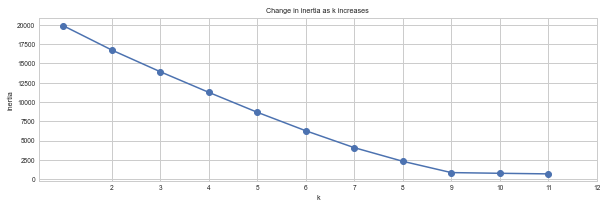

In [90]:
with plt.style.context('seaborn-whitegrid'):

    plt.figure(figsize=(10, 3))
    pd.Series({k: KMeans(k).fit(X_month).inertia_ for k in range(1, 12)}).plot(marker = 'o')
    plt.xticks(range(2, 13))
    
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

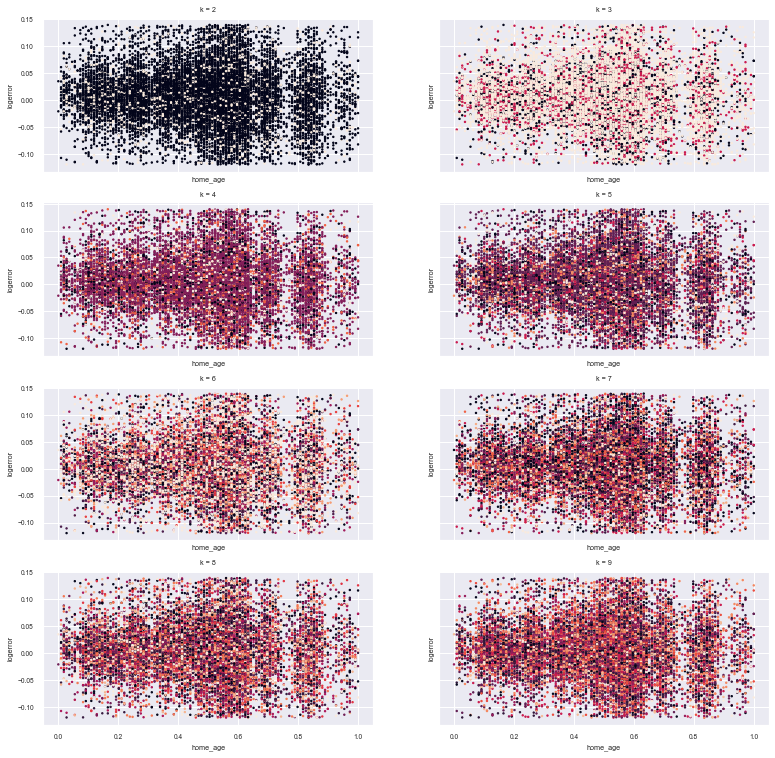

In [91]:
# plotting inertia for number of KMeans clusters

fig, axs = plt.subplots(4, 2, figsize=(13, 13), sharex=True, sharey=True)

for ax, k in zip(axs.ravel(), range(2, 13)):
    
    # creating and fitting KMeans
    clusters = KMeans(k).fit(X_month).predict(X_month)

    X_month["logerror"] = train_dummy["logerror"]

    ax.scatter(
        X_month["home_age"], 
        X_month["logerror"], 
        c = clusters,
        s = 2)

    ax.set(title='k = {}'.format(k), xlabel = 'home_age', ylabel = 'logerror')

In [92]:
# cleaning target in KMeans cluster and creating val and test clusters

X_month = X_month.drop(columns = "logerror")

kmeans = KMeans(n_clusters = 9)
kmeans.fit(X_month)

train_month_clusters = kmeans.predict(X_month)
val_month_clusters = kmeans.predict(X_val)
test_month_clusters = kmeans.predict(X_test)

train_month_clusters

array([8, 3, 6, ..., 5, 4, 1], dtype=int32)

In [93]:
# checking for cleaning

X_month.head()

home_age  transaction_month_January  transaction_month_February  \
49143      0.56                      False                       False   
18505      0.25                      False                       False   
1594       0.68                       True                       False   
35506      0.49                      False                       False   
11229      0.40                      False                       False   

       transaction_month_March  transaction_month_April  \
49143                    False                    False   
18505                    False                     True   
1594                     False                    False   
35506                    False                    False   
11229                     True                    False   

       transaction_month_May  transaction_month_June  transaction_month_July  \
49143                  False                   False                   False   
18505                  False                   False                   False   
1594                   False                   False                   False   
35506                  False                    True                   False   
11229                  False                   False                   False   

       transaction_month_August  transaction_month_September  
49143                     False                         True  
18505                     False                        False  
1594                      False                        False  
35506                     False                        False  
11229                     False                        False

In [94]:
# adding clusters back to original datasets

train_imputed["month_clusters"] = train_month_clusters
validate_imputed["month_clusters"] = val_month_clusters
test_imputed["month_clusters"] = test_month_clusters

train_imputed.head()

parcel_id  home_value  logerror  bathroom_count  bedroom_count  \
49143  11279487    74239.00     -0.02            1.00           3.00   
18505  14235131   426984.00     -0.02            2.50           3.00   
1594   12461319   399808.00      0.02            2.00           3.00   
35506  14139772    71763.00     -0.06            2.00           3.00   
11229  14491761   354226.00     -0.03            1.00           2.00   

       living_sq_feet county_by_fips  latitude  longitude  property_sq_feet  \
49143            0.21      LA County      0.98       0.68              0.55   
18505            0.35  Orange County      0.33       0.86              0.13   
1594             0.36      LA County      0.36       0.67              0.43   
35506            0.34  Orange County      0.41       0.82              0.55   
11229            0.21  Orange County      0.21       0.94              0.33   

      county_zoning_code  blockgroup_assignment  year_built  home_age  \
49143               0100                   0.01        0.44      0.56   
18505                122                   0.30        0.75      0.25   
1594                0100                   0.01        0.32      0.68   
35506                122                   0.30        0.51      0.49   
11229                122                   0.30        0.60      0.40   

      transaction_month     home_age_binned living_sqfeet_binned  \
49143         September    mid_20th_century   360_to_1240_sqfeet   
18505             April         new_century  1241_to_1565_sqfeet   
1594            January  early_20th_century  1241_to_1565_sqfeet   
35506              June   late_20th_century  1241_to_1565_sqfeet   
11229             March   late_20th_century   360_to_1240_sqfeet   

      transaction_quarter  month_clusters  
49143      q3_transaction               8  
18505      q2_transaction               3  
1594       q1_transaction               6  
35506      q2_transaction               1  
11229      q1_transaction               4

In [95]:
# checking the log error mean across months

pd.DataFrame(train_imputed.groupby("transaction_month")["logerror"].mean()).sort_index()

logerror
transaction_month          
April                  0.00
August                 0.01
February               0.01
January                0.01
July                   0.01
June                   0.00
March                  0.00
May                    0.00
September              0.01

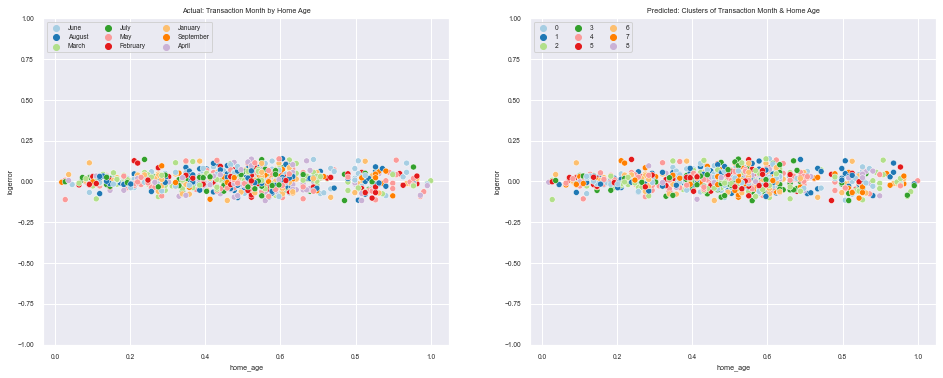

In [96]:
# seeing how clusters compare against actual month & home age plots

plt.subplots(1, 2, figsize = (16, 6), sharex = True, sharey = False)

plt.subplot(121)
sns.scatterplot(
        x = "home_age",
        y = "logerror",
        data = train_imputed.sample(1000, random_state = 14), 
        hue = "transaction_month",
        # hue_order = [
        # 'January',
        # 'August',
        # 'April',
        # 'June',
        # 'May',
        # 'July',
        # 'March',
        # 'February',
        # 'September'],
        palette = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6']
)

plt.title("Actual: Transaction Month by Home Age")
plt.legend(loc = 'upper left', ncol = 3)
plt.ylim(-1, 1)

plt.subplot(122)
sns.scatterplot(
        x = "home_age",
        y = "logerror",
        data = train_imputed.sample(1000, random_state = 14), 
        hue = "month_clusters",
        # hue_order = [0, 1, 2, 3, 4, 5, 6, 7, 8],
        palette = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6']
)

plt.title("Predicted: Clusters of Transaction Month & Home Age")
plt.legend(loc = 'upper left', ncol = 3)
plt.ylim(-1, 1)
plt.show()

----
### <u>``2nd Cluster: Build Era and Living Sq. Feet``</u>

In [97]:
# checking the df head

train_dummy.columns.tolist()

['parcel_id',
 'home_value',
 'logerror',
 'living_sq_feet',
 'latitude',
 'longitude',
 'property_sq_feet',
 'county_zoning_code',
 'blockgroup_assignment',
 'year_built',
 'home_age',
 'transaction_month_April',
 'transaction_month_August',
 'transaction_month_February',
 'transaction_month_January',
 'transaction_month_July',
 'transaction_month_June',
 'transaction_month_March',
 'transaction_month_May',
 'transaction_month_September',
 'home_age_binned_new_century',
 'home_age_binned_late_20th_century',
 'home_age_binned_mid_20th_century',
 'home_age_binned_early_20th_century',
 'bathroom_count_1.0',
 'bathroom_count_1.5',
 'bathroom_count_2.0',
 'bathroom_count_2.5',
 'bathroom_count_3.0',
 'bathroom_count_3.5',
 'bathroom_count_4.0',
 'bathroom_count_4.5',
 'bedroom_count_1.0',
 'bedroom_count_2.0',
 'bedroom_count_3.0',
 'bedroom_count_4.0',
 'bedroom_count_5.0',
 'county_by_fips_LA County',
 'county_by_fips_Orange County',
 'county_by_fips_Ventura County',
 'living_sqfeet_binn

In [98]:
# generating second (2) cluster: build era and living sq feet

X_era = train_dummy[[
    'living_sq_feet',
    'home_age_binned_new_century',
    'home_age_binned_late_20th_century',
    'home_age_binned_mid_20th_century',
    'home_age_binned_early_20th_century']]

val_era = validate_dummy[[
    'living_sq_feet',
    'home_age_binned_new_century',
    'home_age_binned_late_20th_century',
    'home_age_binned_mid_20th_century',
    'home_age_binned_early_20th_century']]

test_era = test_dummy[[
    'living_sq_feet',
    'home_age_binned_new_century',
    'home_age_binned_late_20th_century',
    'home_age_binned_mid_20th_century',
    'home_age_binned_early_20th_century']]


X_era.head()

living_sq_feet  home_age_binned_new_century  \
49143            0.21                        False   
18505            0.35                         True   
1594             0.36                        False   
35506            0.34                        False   
11229            0.21                        False   

       home_age_binned_late_20th_century  home_age_binned_mid_20th_century  \
49143                              False                              True   
18505                              False                             False   
1594                               False                             False   
35506                               True                             False   
11229                               True                             False   

       home_age_binned_early_20th_century  
49143                               False  
18505                               False  
1594                                 True  
35506                               False  
11229                               False

In [99]:
# creating the KMeans cluster object

kmeans = KMeans(n_clusters = 4)
kmeans.fit(X_era)

clusters = kmeans.predict(X_era)
clusters

array([0, 1, 3, ..., 1, 2, 0], dtype=int32)

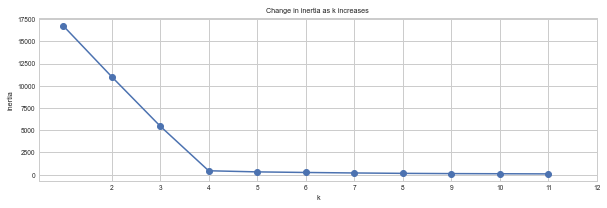

In [100]:
with plt.style.context('seaborn-whitegrid'):

    plt.figure(figsize=(10, 3))
    pd.Series({k: KMeans(k).fit(X_era).inertia_ for k in range(1, 12)}).plot(marker = 'o')
    plt.xticks(range(2, 13))
    
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

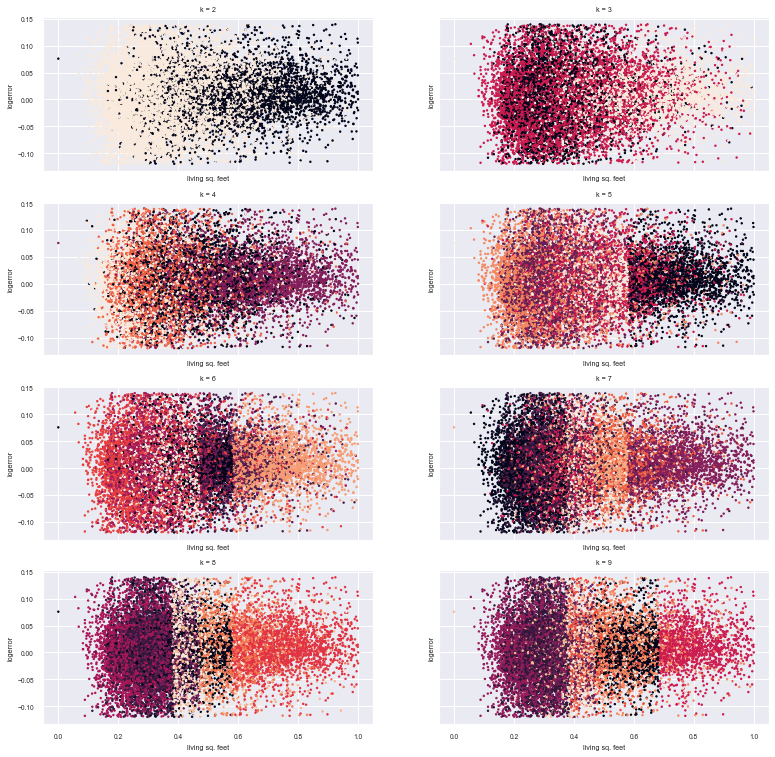

In [101]:
# plotting inertia for number of KMeans clusters

fig, axs = plt.subplots(4, 2, figsize=(13, 13), sharex=True, sharey=True)

for ax, k in zip(axs.ravel(), range(2, 10)):
    # creating and fitting KMeans
    clusters = KMeans(k).fit(X_era).predict(X_era)

    X_era["logerror"] = train_dummy["logerror"]

    ax.scatter(
        X_era["living_sq_feet"], 
        X_era["logerror"], 
        c = clusters,
        s = 2)

    ax.set(title='k = {}'.format(k), xlabel = 'living sq. feet', ylabel = 'logerror')

In [102]:
# cleaning target in KMeans cluster 

X_era = X_era.drop(columns = "logerror")

kmeans = KMeans(n_clusters = 4)
kmeans.fit(X_era)

train_era_clusters = kmeans.predict(X_era)
validate_era_clusters = kmeans.predict(val_era)
test_era_clusters = kmeans.predict(test_era)

train_era_clusters

array([1, 2, 0, ..., 2, 3, 1], dtype=int32)

In [103]:
# checking the df head
X_era.head()

living_sq_feet  home_age_binned_new_century  \
49143            0.21                        False   
18505            0.35                         True   
1594             0.36                        False   
35506            0.34                        False   
11229            0.21                        False   

       home_age_binned_late_20th_century  home_age_binned_mid_20th_century  \
49143                              False                              True   
18505                              False                             False   
1594                               False                             False   
35506                               True                             False   
11229                               True                             False   

       home_age_binned_early_20th_century  
49143                               False  
18505                               False  
1594                                 True  
35506                               False  
11229                               False

In [104]:
# adding clusters to original datasets

train_imputed["era_clusters"] = train_era_clusters
validate_imputed["era_clusters"] = validate_era_clusters
test_imputed["era_clusters"] = test_era_clusters

train_imputed.head()

parcel_id  home_value  logerror  bathroom_count  bedroom_count  \
49143  11279487    74239.00     -0.02            1.00           3.00   
18505  14235131   426984.00     -0.02            2.50           3.00   
1594   12461319   399808.00      0.02            2.00           3.00   
35506  14139772    71763.00     -0.06            2.00           3.00   
11229  14491761   354226.00     -0.03            1.00           2.00   

       living_sq_feet county_by_fips  latitude  longitude  property_sq_feet  \
49143            0.21      LA County      0.98       0.68              0.55   
18505            0.35  Orange County      0.33       0.86              0.13   
1594             0.36      LA County      0.36       0.67              0.43   
35506            0.34  Orange County      0.41       0.82              0.55   
11229            0.21  Orange County      0.21       0.94              0.33   

      county_zoning_code  blockgroup_assignment  year_built  home_age  \
49143               0100                   0.01        0.44      0.56   
18505                122                   0.30        0.75      0.25   
1594                0100                   0.01        0.32      0.68   
35506                122                   0.30        0.51      0.49   
11229                122                   0.30        0.60      0.40   

      transaction_month     home_age_binned living_sqfeet_binned  \
49143         September    mid_20th_century   360_to_1240_sqfeet   
18505             April         new_century  1241_to_1565_sqfeet   
1594            January  early_20th_century  1241_to_1565_sqfeet   
35506              June   late_20th_century  1241_to_1565_sqfeet   
11229             March   late_20th_century   360_to_1240_sqfeet   

      transaction_quarter  month_clusters  era_clusters  
49143      q3_transaction               8             1  
18505      q2_transaction               3             2  
1594       q1_transaction               6             0  
35506      q2_transaction               1             3  
11229      q1_transaction               4             3

In [105]:
# mean log error per home era

pd.DataFrame(train_imputed.groupby("home_age_binned")["logerror"].mean()).sort_index()

logerror
home_age_binned             
new_century             0.01
late_20th_century       0.01
mid_20th_century        0.00
early_20th_century      0.00

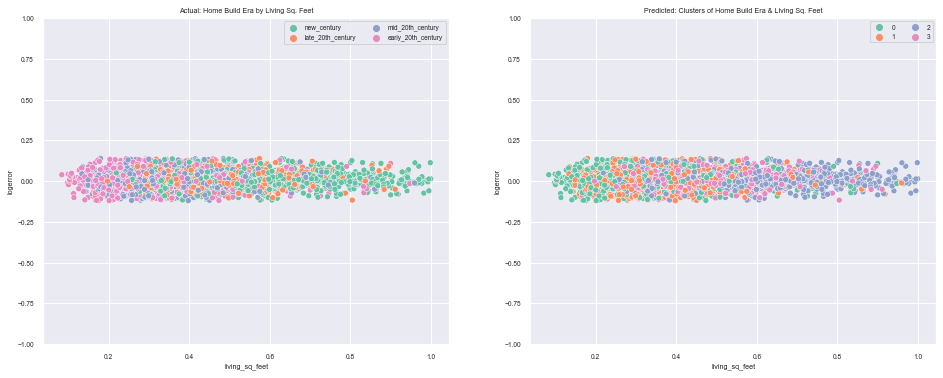

In [106]:
# seeing how clusters compare against actual month & home age plots

plt.subplots(1, 2, figsize = (16, 6), sharex = True, sharey = False)

plt.subplot(121)
sns.scatterplot(
        x = "living_sq_feet",
        y = "logerror",
        data = train_imputed.sample(5000, random_state = 14),
        hue = "home_age_binned",
        # hue_order = ["early_20th_century", "late_20th_century", "mid_20th_century", "new_century"],
        palette = ['#66c2a5','#fc8d62','#8da0cb','#e78ac3']
)


plt.title("Actual: Home Build Era by Living Sq. Feet")
plt.legend(loc = 'upper right', ncol = 2)
plt.ylim(-1, 1)

plt.subplot(122)
sns.scatterplot(
        x = "living_sq_feet",
        y = "logerror",
        data = train_imputed.sample(5000, random_state = 14), 
        hue = "era_clusters",
        # hue_order = [0, 1, 2, 3],
        palette = ['#66c2a5','#fc8d62','#8da0cb','#e78ac3']
)

# 0 = early 20th
# 1 = new century
# 2 = mid century
# 3 = late 19th

plt.title("Predicted: Clusters of Home Build Era & Living Sq. Feet")
plt.legend(loc = 'upper right', ncol = 2)
plt.ylim(-1, 1)
plt.show()

----
### <u>``3rd Cluster: Size of Homes Binned and Home Age``</u>

In [107]:
# checking the df columns

train_dummy.columns.tolist()

['parcel_id',
 'home_value',
 'logerror',
 'living_sq_feet',
 'latitude',
 'longitude',
 'property_sq_feet',
 'county_zoning_code',
 'blockgroup_assignment',
 'year_built',
 'home_age',
 'transaction_month_April',
 'transaction_month_August',
 'transaction_month_February',
 'transaction_month_January',
 'transaction_month_July',
 'transaction_month_June',
 'transaction_month_March',
 'transaction_month_May',
 'transaction_month_September',
 'home_age_binned_new_century',
 'home_age_binned_late_20th_century',
 'home_age_binned_mid_20th_century',
 'home_age_binned_early_20th_century',
 'bathroom_count_1.0',
 'bathroom_count_1.5',
 'bathroom_count_2.0',
 'bathroom_count_2.5',
 'bathroom_count_3.0',
 'bathroom_count_3.5',
 'bathroom_count_4.0',
 'bathroom_count_4.5',
 'bedroom_count_1.0',
 'bedroom_count_2.0',
 'bedroom_count_3.0',
 'bedroom_count_4.0',
 'bedroom_count_5.0',
 'county_by_fips_LA County',
 'county_by_fips_Orange County',
 'county_by_fips_Ventura County',
 'living_sqfeet_binn

In [108]:
# seeting X features for home size cluster

X_home_size = train_dummy[[ 
    'home_age',
    'living_sqfeet_binned_360_to_1240_sqfeet',
    'living_sqfeet_binned_1241_to_1565_sqfeet',
    'living_sqfeet_binned_1566_to_2036_sqfeet',
    'living_sqfeet_binned_2037_to_3855_sqfeet'
]]

val_home_size = validate_dummy[[ 
    'home_age',
    'living_sqfeet_binned_360_to_1240_sqfeet',
    'living_sqfeet_binned_1241_to_1565_sqfeet',
    'living_sqfeet_binned_1566_to_2036_sqfeet',
    'living_sqfeet_binned_2037_to_3855_sqfeet'
]]

test_home_size = test_dummy[[ 
    'home_age',
    'living_sqfeet_binned_360_to_1240_sqfeet',
    'living_sqfeet_binned_1241_to_1565_sqfeet',
    'living_sqfeet_binned_1566_to_2036_sqfeet',
    'living_sqfeet_binned_2037_to_3855_sqfeet'
]]

X_home_size.head()

home_age  living_sqfeet_binned_360_to_1240_sqfeet  \
49143      0.56                                     True   
18505      0.25                                    False   
1594       0.68                                    False   
35506      0.49                                    False   
11229      0.40                                     True   

       living_sqfeet_binned_1241_to_1565_sqfeet  \
49143                                     False   
18505                                      True   
1594                                       True   
35506                                      True   
11229                                     False   

       living_sqfeet_binned_1566_to_2036_sqfeet  \
49143                                     False   
18505                                     False   
1594                                      False   
35506                                     False   
11229                                     False   

       living_sqfeet_binned_2037_to_3855_sqfeet  
49143                                     False  
18505                                     False  
1594                                      False  
35506                                     False  
11229                                     False

In [109]:
# creating the KMeans cluster object

kmeans = KMeans(n_clusters = 4)
kmeans.fit(X_home_size)

clusters = kmeans.predict(X_home_size)
clusters

array([2, 3, 3, ..., 1, 3, 2], dtype=int32)

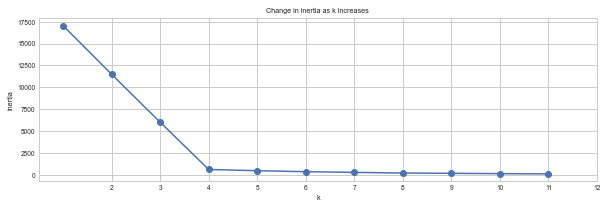

In [110]:
with plt.style.context('seaborn-whitegrid'):

    plt.figure(figsize=(10, 3))
    pd.Series({k: KMeans(k).fit(X_home_size).inertia_ for k in range(1, 12)}).plot(marker = 'o')
    plt.xticks(range(2, 13))
    
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

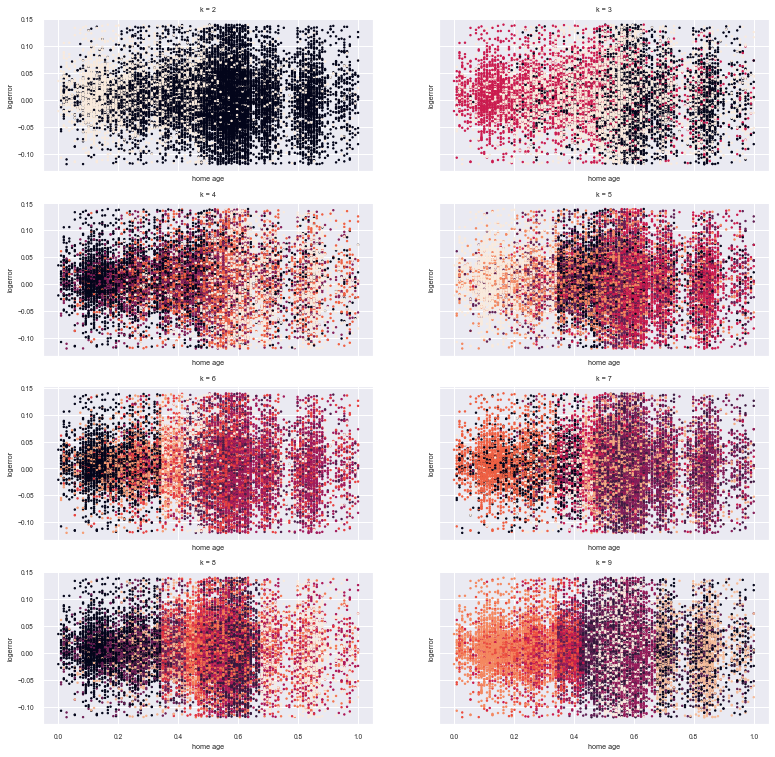

In [111]:
# plotting inertia for number of KMeans clusters

fig, axs = plt.subplots(4, 2, figsize=(13, 13), sharex=True, sharey=True)

for ax, k in zip(axs.ravel(), range(2, 10)):
    # creating and fitting KMeans
    clusters = KMeans(k).fit(X_home_size).predict(X_home_size)

    X_home_size["logerror"] = train_dummy["logerror"]

    ax.scatter(
        X_home_size["home_age"], 
        X_home_size["logerror"], 
        c = clusters,
        s = 2)

    ax.set(title='k = {}'.format(k), xlabel = 'home age', ylabel = 'logerror')

In [112]:
# cleaning target in KMeans cluster 

X_home_size = X_home_size.drop(columns = "logerror")

kmeans = KMeans(n_clusters = 4)
kmeans.fit(X_home_size)

train_size_clusters = kmeans.predict(X_home_size)
val_size_clusters = kmeans.predict(val_home_size)
test_size_clusters = kmeans.predict(test_home_size)

train_size_clusters

array([2, 0, 0, ..., 1, 0, 2], dtype=int32)

In [113]:
# checking df head

X_home_size.head() # checks out!

home_age  living_sqfeet_binned_360_to_1240_sqfeet  \
49143      0.56                                     True   
18505      0.25                                    False   
1594       0.68                                    False   
35506      0.49                                    False   
11229      0.40                                     True   

       living_sqfeet_binned_1241_to_1565_sqfeet  \
49143                                     False   
18505                                      True   
1594                                       True   
35506                                      True   
11229                                     False   

       living_sqfeet_binned_1566_to_2036_sqfeet  \
49143                                     False   
18505                                     False   
1594                                      False   
35506                                     False   
11229                                     False   

       living_sqfeet_binned_2037_to_3855_sqfeet  
49143                                     False  
18505                                     False  
1594                                      False  
35506                                     False  
11229                                     False

In [114]:
# adding clusters to original datasets

train_imputed["size_clusters"] = train_size_clusters
validate_imputed["size_clusters"] = val_size_clusters
test_imputed["size_clusters"] = test_size_clusters

train_imputed.head()

parcel_id  home_value  logerror  bathroom_count  bedroom_count  \
49143  11279487    74239.00     -0.02            1.00           3.00   
18505  14235131   426984.00     -0.02            2.50           3.00   
1594   12461319   399808.00      0.02            2.00           3.00   
35506  14139772    71763.00     -0.06            2.00           3.00   
11229  14491761   354226.00     -0.03            1.00           2.00   

       living_sq_feet county_by_fips  latitude  longitude  property_sq_feet  \
49143            0.21      LA County      0.98       0.68              0.55   
18505            0.35  Orange County      0.33       0.86              0.13   
1594             0.36      LA County      0.36       0.67              0.43   
35506            0.34  Orange County      0.41       0.82              0.55   
11229            0.21  Orange County      0.21       0.94              0.33   

       ... blockgroup_assignment  year_built  home_age  transaction_month  \
49143  ...                  0.01        0.44      0.56          September   
18505  ...                  0.30        0.75      0.25              April   
1594   ...                  0.01        0.32      0.68            January   
35506  ...                  0.30        0.51      0.49               June   
11229  ...                  0.30        0.60      0.40              March   

          home_age_binned living_sqfeet_binned transaction_quarter  \
49143    mid_20th_century   360_to_1240_sqfeet      q3_transaction   
18505         new_century  1241_to_1565_sqfeet      q2_transaction   
1594   early_20th_century  1241_to_1565_sqfeet      q1_transaction   
35506   late_20th_century  1241_to_1565_sqfeet      q2_transaction   
11229   late_20th_century   360_to_1240_sqfeet      q1_transaction   

      month_clusters  era_clusters  size_clusters  
49143              8             1              2  
18505              3             2              0  
1594               6             0              0  
35506              1             3              0  
11229              4             3              2  

[5 rows x 21 columns]

In [115]:
# log error mean by home size bins

pd.DataFrame(train_imputed.groupby("living_sqfeet_binned")["logerror"].mean()).sort_index()

logerror
living_sqfeet_binned          
360_to_1240_sqfeet        0.00
1241_to_1565_sqfeet       0.00
1566_to_2036_sqfeet       0.01
2037_to_3855_sqfeet       0.01

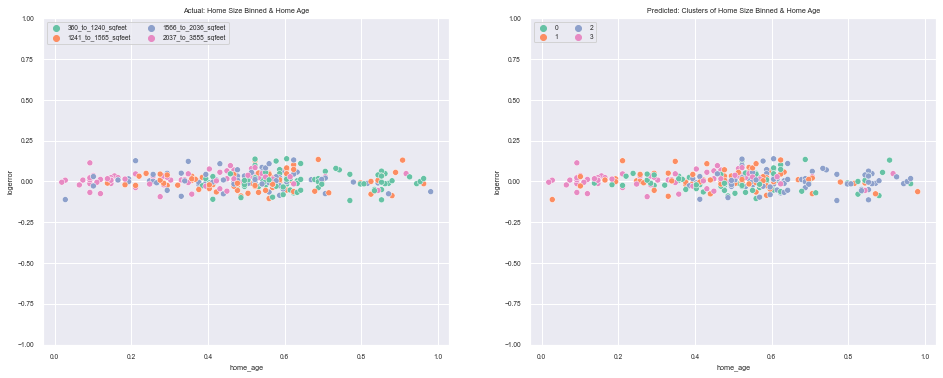

In [116]:
# seeing how clusters compare against actual month & home age plots

plt.subplots(1, 2, figsize = (16, 6), sharex = True, sharey = False)

plt.subplot(121)
sns.scatterplot(
        x = "home_age",
        y = "logerror",
        data = train_imputed.sample(300, random_state = 14),
        hue = "living_sqfeet_binned",
        # hue_order = ["360_to_1240_sqfeet", "1241_to_1565_sqfeet", "1566_to_2036_sqfeet", "2037_to_3855_sqfeet"],
        palette = ['#66c2a5','#fc8d62','#8da0cb','#e78ac3'],
)

plt.title("Actual: Home Size Binned & Home Age")
plt.legend(loc = 'upper left', ncol = 2)
plt.ylim(-1, 1)

plt.subplot(122)
sns.scatterplot(
        x = "home_age",
        y = "logerror",
        data = train_imputed.sample(300, random_state = 14), 
        hue = "size_clusters",
        # hue_order = [0, 1, 2, 3],
        palette = ['#66c2a5','#fc8d62','#8da0cb','#e78ac3']
)

plt.title("Predicted: Clusters of Home Size Binned & Home Age")
plt.legend(loc = 'upper left', ncol = 2)
plt.ylim(-1, 1)
plt.show()

---- 
### ``Cluster Exploration``

In [117]:
# let's check the df head

train_imputed.columns.tolist()

['parcel_id',
 'home_value',
 'logerror',
 'bathroom_count',
 'bedroom_count',
 'living_sq_feet',
 'county_by_fips',
 'latitude',
 'longitude',
 'property_sq_feet',
 'county_zoning_code',
 'blockgroup_assignment',
 'year_built',
 'home_age',
 'transaction_month',
 'home_age_binned',
 'living_sqfeet_binned',
 'transaction_quarter',
 'month_clusters',
 'era_clusters',
 'size_clusters']

In [118]:
# checking the df shape

train_imputed.shape

(21578, 21)

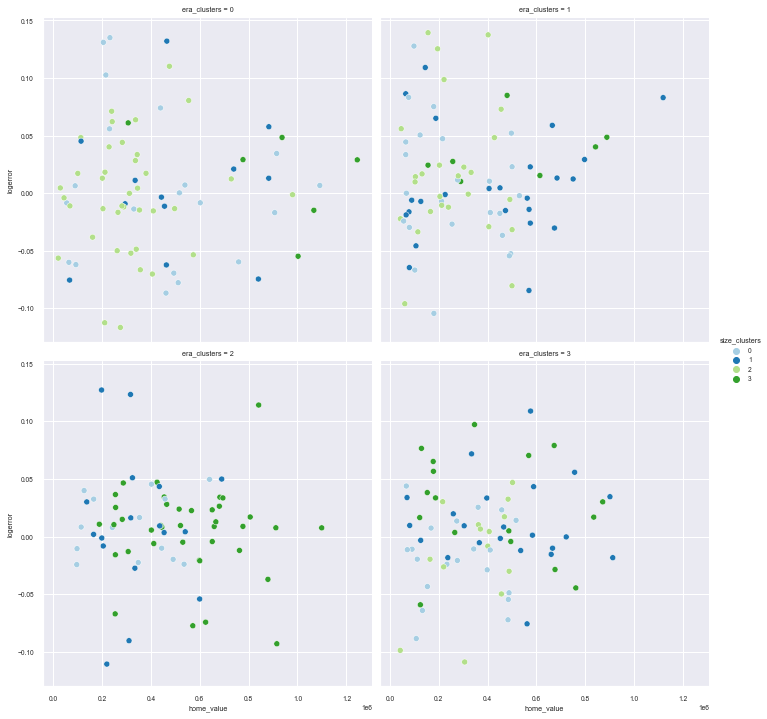

In [119]:
# plotting clusters
# era cluster first

sns.relplot(
    data = train_imputed.sample(300, random_state = 14), 
    x = "home_value", 
    y = "logerror", 
    col = "era_clusters", 
    hue = "size_clusters",
    palette = ['#a6cee3','#1f78b4','#b2df8a','#33a02c'],
    col_wrap = 2)


plt.show()

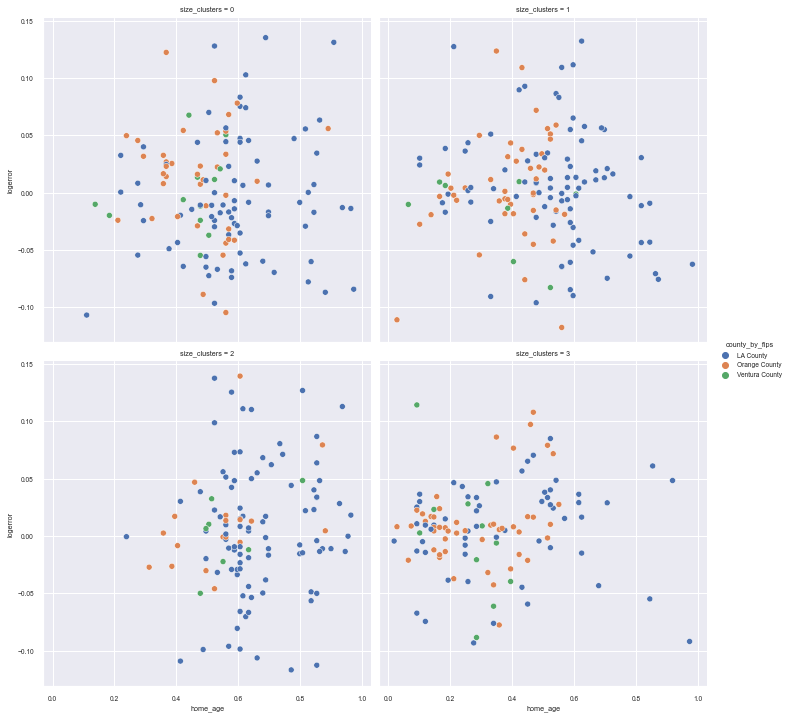

In [120]:
# plotting clusters
# month clusters

sns.relplot(data = train_imputed.sample(500, random_state = 14), x = "home_age", y = "logerror", col = "size_clusters", hue = "county_by_fips", col_wrap = 2)
plt.show()

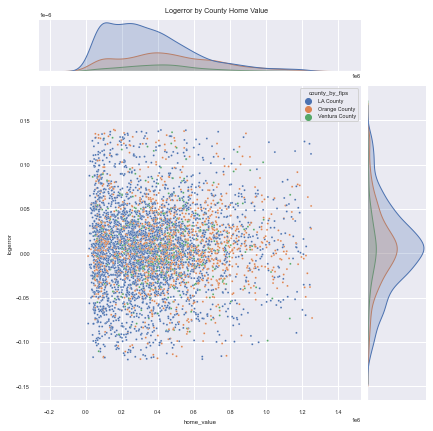

In [121]:
# plt.figure(figsize = (20, 3))
sns.set(font_scale = .5)

p = sns.jointplot(
    data = train_imputed.sample(5000, random_state = 14),
    x = "home_value", 
    y = "logerror", 
    hue = "county_by_fips",
    s = 4)

p.fig.suptitle("Logerror by County Home Value")
p.fig.tight_layout()
p.fig.subplots_adjust(top = .95) # Reduce plot to make room 

plt.show()

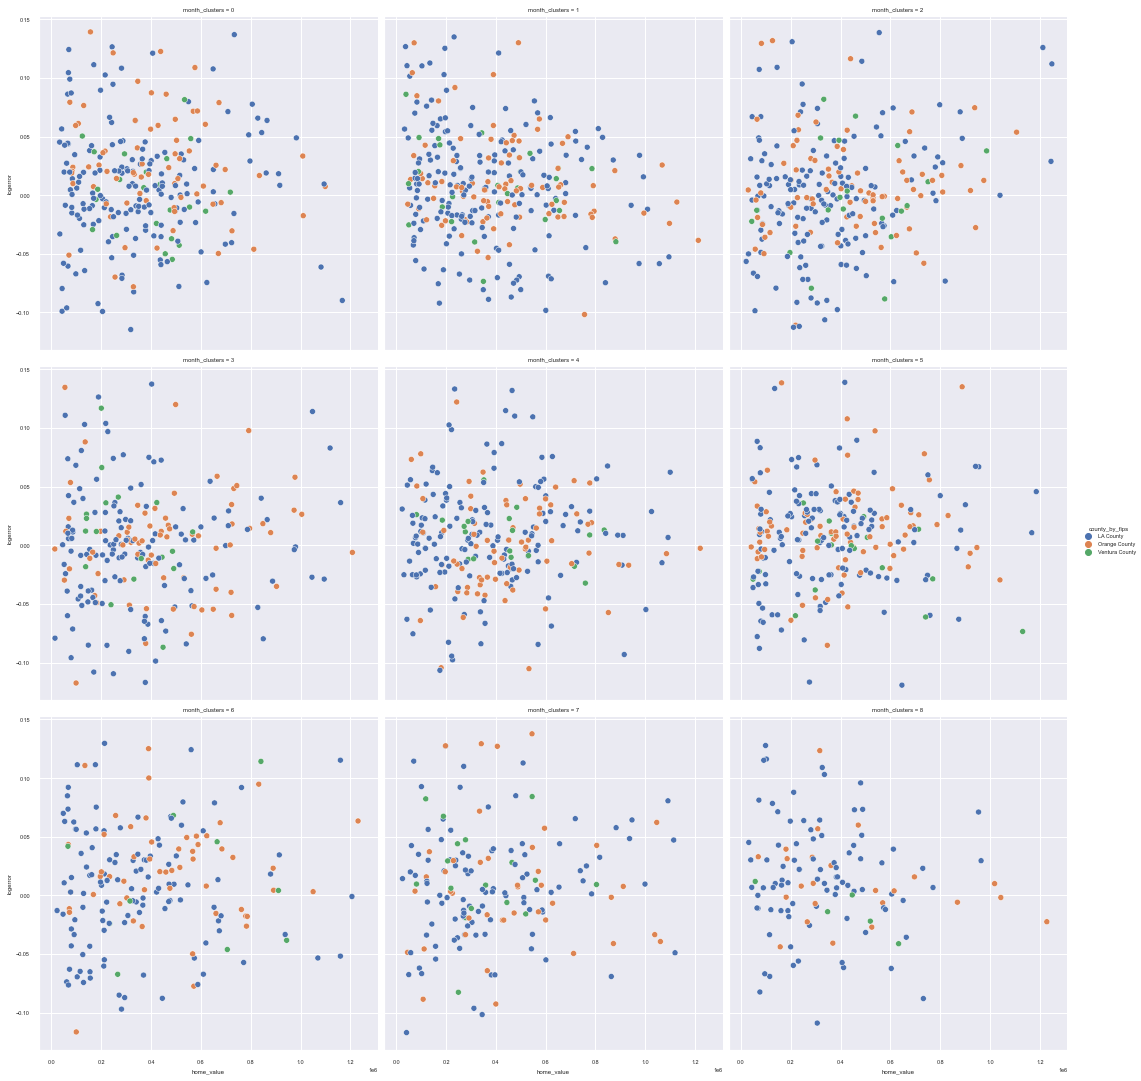

In [122]:
# plotting clusters
# month clusters

sns.relplot(data = train_imputed.sample(2000, random_state = 14), x = "home_value", y = "logerror", col = "month_clusters", hue = "county_by_fips", col_wrap = 3)
plt.show()

In [123]:
# creating dummy dataframes with generated clusters

# train dataset
train_dummy = pd.get_dummies(data = train_imputed, columns = [
    'transaction_month',
    'county_by_fips',
    'home_age_binned',
    'living_sqfeet_binned',
    'bathroom_count',
    'bedroom_count',
    'month_clusters',
    'era_clusters',
    'size_clusters'],
    drop_first = False, 
    dtype = bool)

# validate dataset
validate_dummy = pd.get_dummies(data = validate_imputed, columns = [
    'transaction_month',
    'county_by_fips',
    'home_age_binned',
    'living_sqfeet_binned',
    'bathroom_count',
    'bedroom_count',
    'month_clusters',
    'era_clusters',
    'size_clusters'],
    drop_first = False, 
    dtype = bool)

# test dataset
test_dummy = pd.get_dummies(data = test_imputed, columns = [
    'transaction_month',
    'county_by_fips',
    'home_age_binned',
    'living_sqfeet_binned',
    'bathroom_count',
    'bedroom_count',
    'month_clusters',
    'era_clusters',
    'size_clusters'],
    drop_first = False, 
    dtype = bool)

In [124]:
# checking the dataframe

train_dummy.head()

parcel_id  home_value  logerror  living_sq_feet  latitude  longitude  \
49143  11279487    74239.00     -0.02            0.21      0.98       0.68   
18505  14235131   426984.00     -0.02            0.35      0.33       0.86   
1594   12461319   399808.00      0.02            0.36      0.36       0.67   
35506  14139772    71763.00     -0.06            0.34      0.41       0.82   
11229  14491761   354226.00     -0.03            0.21      0.21       0.94   

       property_sq_feet county_zoning_code  blockgroup_assignment  year_built  \
49143              0.55               0100                   0.01        0.44   
18505              0.13                122                   0.30        0.75   
1594               0.43               0100                   0.01        0.32   
35506              0.55                122                   0.30        0.51   
11229              0.33                122                   0.30        0.60   

       ...  month_clusters_7 month_clusters_8  era_clusters_0  era_clusters_1  \
49143  ...             False             True           False            True   
18505  ...             False            False           False           False   
1594   ...             False            False            True           False   
35506  ...             False            False           False           False   
11229  ...             False            False           False           False   

       era_clusters_2  era_clusters_3  size_clusters_0  size_clusters_1  \
49143           False           False            False            False   
18505            True           False             True            False   
1594            False           False             True            False   
35506           False            True             True            False   
11229           False            True            False            False   

       size_clusters_2  size_clusters_3  
49143             True            False  
18505            False            False  
1594             False            False  
35506            False            False  
11229             True            False  

[5 rows x 62 columns]

In [125]:
# checking the shape

train_dummy.shape

(21578, 62)

In [126]:
# establishing logerror baseline

def establish_baseline(train, validate):

    baseline = round(train["logerror"].mean(), 2)

    train['baseline'] = baseline
    validate['baseline'] = baseline

    train_rmse = sqrt(mean_squared_error(train.logerror, train.baseline))
    validate_rmse = sqrt(mean_squared_error(validate.logerror, validate.baseline))

    print('Train baseline RMSE: {:.2f}'.format(train_rmse))
    print('Validate baseline RMSE: {:.2f}'.format(validate_rmse))

    train = train.drop(columns = "baseline")
    validate = validate.drop(columns = "baseline")
    print()
    print(f'train shape: {train.shape}')
    print(f'validate shape: {validate.shape}')

    return train, validate

In [127]:
# establishing dataset baselines for train and validate df

train_dummy, validate_dummy = establish_baseline(train_dummy, validate_dummy)

Train baseline RMSE: 0.05
Validate baseline RMSE: 0.05

train shape: (21578, 62)
validate shape: (9249, 62)


In [128]:
# let's first resplit the data to visualize clusters against other features
# 2nd split: splitting larger datasets into x and y variables

X_train = train_dummy.drop(columns = [
    "logerror", 
    "home_value",
    'blockgroup_assignment',
    'parcel_id',
    'transaction_quarter',
    'county_zoning_code'])

y_train = train_dummy["logerror"]

X_validate = validate_dummy.drop(columns = [
    "logerror", 
    "home_value",
    'blockgroup_assignment',
    'parcel_id',
    'transaction_quarter',
    'county_zoning_code'])

y_validate = validate_dummy["logerror"]

X_test = test_dummy.drop(columns = [
    "logerror", 
    "home_value",
    'blockgroup_assignment',
    'parcel_id',
    'transaction_quarter',
    'county_zoning_code'])
    
y_test = test_dummy["logerror"]

In [129]:
# checking the shape

print(X_train.shape)
print(y_train.shape)

(21578, 56)
(21578,)


In [130]:
X_train.dtypes

living_sq_feet                              float64
latitude                                    float64
longitude                                   float64
property_sq_feet                            float64
year_built                                  float64
home_age                                    float64
transaction_month_April                        bool
transaction_month_August                       bool
transaction_month_February                     bool
transaction_month_January                      bool
transaction_month_July                         bool
transaction_month_June                         bool
transaction_month_March                        bool
transaction_month_May                          bool
transaction_month_September                    bool
county_by_fips_LA County                       bool
county_by_fips_Orange County                   bool
county_by_fips_Ventura County                  bool
home_age_binned_new_century                    bool
home_age_bin

In [131]:
# converting category columns to object type

# X_train[["home_age_binned", "living_sqfeet_binned"]] = X_train[["home_age_binned", "living_sqfeet_binned"]].astype(object)

In [132]:
# creating a recursive feature eliminate function

def recursive_feature_eliminate(X_train, y_train, number_of_top_features):

    # initialize the ML algorithm
    lm = LinearRegression()

    rfe = RFE(lm, n_features_to_select = number_of_top_features)

    # fit the data using RFE
    rfe.fit(X_train, y_train) 

    # get the mask of the columns selected
    feature_mask = rfe.support_

    # get list of the column names
    rfe_features = X_train.iloc[:,feature_mask].columns.tolist()

    # view list of columns and their ranking
    # get the ranks using "rfe.ranking" method
    variable_ranks = rfe.ranking_

    # get the variable names
    variable_names = X_train.columns.tolist()

    # combine ranks and names into a df for clean viewing
    rfe_ranks_df = pd.DataFrame({'Feature': variable_names, 'Ranking': variable_ranks})

    # sort the df by rank
    return rfe_ranks_df.sort_values('Ranking')

In [133]:
X_train.columns.tolist()

['living_sq_feet',
 'latitude',
 'longitude',
 'property_sq_feet',
 'year_built',
 'home_age',
 'transaction_month_April',
 'transaction_month_August',
 'transaction_month_February',
 'transaction_month_January',
 'transaction_month_July',
 'transaction_month_June',
 'transaction_month_March',
 'transaction_month_May',
 'transaction_month_September',
 'county_by_fips_LA County',
 'county_by_fips_Orange County',
 'county_by_fips_Ventura County',
 'home_age_binned_new_century',
 'home_age_binned_late_20th_century',
 'home_age_binned_mid_20th_century',
 'home_age_binned_early_20th_century',
 'living_sqfeet_binned_360_to_1240_sqfeet',
 'living_sqfeet_binned_1241_to_1565_sqfeet',
 'living_sqfeet_binned_1566_to_2036_sqfeet',
 'living_sqfeet_binned_2037_to_3855_sqfeet',
 'bathroom_count_1.0',
 'bathroom_count_1.5',
 'bathroom_count_2.0',
 'bathroom_count_2.5',
 'bathroom_count_3.0',
 'bathroom_count_3.5',
 'bathroom_count_4.0',
 'bathroom_count_4.5',
 'bedroom_count_1.0',
 'bedroom_count_2.0'

In [134]:
# removing duplicate cluster columns (home_era, home_size, transaction_months)

X_train = X_train.drop(columns = [
'home_age_binned_new_century',               
'home_age_binned_late_20th_century',             
'home_age_binned_mid_20th_century',               
'home_age_binned_early_20th_century',                 
'living_sqfeet_binned_360_to_1240_sqfeet',
'living_sqfeet_binned_1241_to_1565_sqfeet',
'living_sqfeet_binned_1566_to_2036_sqfeet',
'living_sqfeet_binned_2037_to_3855_sqfeet',
'transaction_month_April',                      
'transaction_month_August',                      
'transaction_month_February',                    
'transaction_month_January',                     
'transaction_month_July',                       
'transaction_month_June',                        
'transaction_month_March',                       
'transaction_month_May',                         
'transaction_month_September',
'county_by_fips_LA County',
'county_by_fips_Orange County',
'county_by_fips_Ventura County',
'bathroom_count_1.0',
'bathroom_count_1.5',
'bathroom_count_2.0',
'bathroom_count_2.5',
'bathroom_count_3.0',
'bathroom_count_3.5',
'bathroom_count_4.0',
'bathroom_count_4.5',
'bedroom_count_1.0',
'bedroom_count_2.0',
'bedroom_count_3.0',
'bedroom_count_4.0',
'bedroom_count_5.0',
"year_built",
"home_age",
"living_sq_feet",
"property_sq_feet",
"latitude",
"longitude",
])

X_validate = X_validate.drop(columns = [
'home_age_binned_new_century',               
'home_age_binned_late_20th_century',             
'home_age_binned_mid_20th_century',               
'home_age_binned_early_20th_century',                 
'living_sqfeet_binned_360_to_1240_sqfeet',
'living_sqfeet_binned_1241_to_1565_sqfeet',
'living_sqfeet_binned_1566_to_2036_sqfeet',
'living_sqfeet_binned_2037_to_3855_sqfeet',
'transaction_month_April',                      
'transaction_month_August',                      
'transaction_month_February',                    
'transaction_month_January',                     
'transaction_month_July',                       
'transaction_month_June',                        
'transaction_month_March',                       
'transaction_month_May',                         
'transaction_month_September',
'county_by_fips_LA County',
'county_by_fips_Orange County',
'county_by_fips_Ventura County',
'bathroom_count_1.0',
'bathroom_count_1.5',
'bathroom_count_2.0',
'bathroom_count_2.5',
'bathroom_count_3.0',
'bathroom_count_3.5',
'bathroom_count_4.0',
'bathroom_count_4.5',
'bedroom_count_1.0',
'bedroom_count_2.0',
'bedroom_count_3.0',
'bedroom_count_4.0',
'bedroom_count_5.0',
"year_built",
"home_age",
"living_sq_feet",
"property_sq_feet",
"latitude",
"longitude",
])

X_test = X_test.drop(columns = [
'home_age_binned_new_century',               
'home_age_binned_late_20th_century',             
'home_age_binned_mid_20th_century',               
'home_age_binned_early_20th_century',                 
'living_sqfeet_binned_360_to_1240_sqfeet',
'living_sqfeet_binned_1241_to_1565_sqfeet',
'living_sqfeet_binned_1566_to_2036_sqfeet',
'living_sqfeet_binned_2037_to_3855_sqfeet',
'transaction_month_April',                      
'transaction_month_August',                      
'transaction_month_February',                    
'transaction_month_January',                     
'transaction_month_July',                       
'transaction_month_June',                        
'transaction_month_March',                       
'transaction_month_May',                         
'transaction_month_September',
'county_by_fips_LA County',
'county_by_fips_Orange County',
'county_by_fips_Ventura County',
'bathroom_count_1.0',
'bathroom_count_1.5',
'bathroom_count_2.0',
'bathroom_count_2.5',
'bathroom_count_3.0',
'bathroom_count_3.5',
'bathroom_count_4.0',
'bathroom_count_4.5',
'bedroom_count_1.0',
'bedroom_count_2.0',
'bedroom_count_3.0',
'bedroom_count_4.0',
'bedroom_count_5.0',
"year_built",
"home_age",
"living_sq_feet",
"property_sq_feet",
"latitude",
"longitude",
])

In [135]:
# using sklearn's RFECV function to select best features to include

from sklearn.feature_selection import RFECV

# initiate, and fit

rfecv = RFECV(
    estimator = LinearRegression(),
    min_features_to_select = 5
)

rfecv = rfecv.fit(X_train, y_train)

In [136]:
feature_lst = X_train.columns[rfecv.support_].tolist()
pd.DataFrame(feature_lst).rename(columns = {0: "Features"}).sort_values("Features").reset_index(drop = True)

Features
0     era_clusters_0
1     era_clusters_1
2     era_clusters_2
3     era_clusters_3
4   month_clusters_0
5   month_clusters_1
6   month_clusters_2
7   month_clusters_3
8   month_clusters_4
9   month_clusters_5
10  month_clusters_6
11  month_clusters_7
12  month_clusters_8
13   size_clusters_0
14   size_clusters_1
15   size_clusters_2
16   size_clusters_3

In [137]:
# using the recursive feature elimination function

recursive_feature_eliminate(X_train, y_train, 3).reset_index(drop = True)

Feature  Ranking
0     era_clusters_3        1
1     era_clusters_2        1
2     era_clusters_1        1
3     era_clusters_0        2
4   month_clusters_3        3
5   month_clusters_2        4
6   month_clusters_4        5
7   month_clusters_1        6
8   month_clusters_5        7
9   month_clusters_7        8
10  month_clusters_0        9
11  month_clusters_8       10
12  month_clusters_6       11
13   size_clusters_3       12
14   size_clusters_1       13
15   size_clusters_0       14
16   size_clusters_2       15

In [138]:
# selecting only identified features from RFECV 

X_train = X_train[feature_lst]
X_validate = X_validate[feature_lst]
X_test = X_test[feature_lst]

X_train.head()

month_clusters_0  month_clusters_1  month_clusters_2  month_clusters_3  \
49143             False             False             False             False   
18505             False             False             False              True   
1594              False             False             False             False   
35506             False              True             False             False   
11229             False             False             False             False   

       month_clusters_4  month_clusters_5  month_clusters_6  month_clusters_7  \
49143             False             False             False             False   
18505             False             False             False             False   
1594              False             False              True             False   
35506             False             False             False             False   
11229              True             False             False             False   

       month_clusters_8  era_clusters_0  era_clusters_1  era_clusters_2  \
49143              True           False            True           False   
18505             False           False           False            True   
1594              False            True           False           False   
35506             False           False           False           False   
11229             False           False           False           False   

       era_clusters_3  size_clusters_0  size_clusters_1  size_clusters_2  \
49143           False            False            False             True   
18505           False             True            False            False   
1594            False             True            False            False   
35506            True             True            False            False   
11229            True            False            False             True   

       size_clusters_3  
49143            False  
18505            False  
1594             False  
35506            False  
11229            False

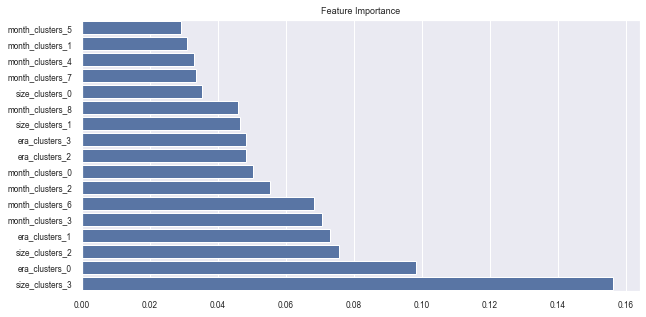

In [139]:
# calculating and plotting feature importance
plt.figure(figsize = (10, 5))
sns.set(style = "darkgrid", font_scale = .75)

rf = RandomForestRegressor(random_state = 123)
rf = rf.fit(X_train, y_train)

sorted_idx = rf.feature_importances_.argsort()

sns.barplot(rf.feature_importances_[sorted_idx], X_train.columns[sorted_idx], orient = "h", color = "b")

plt.title("Feature Importance")
plt.show()

In [140]:
# feature importance of only clusters

# plt.figure(figsize = (10, 5))
# sns.set(style = "darkgrid", font_scale = .75)

# rf = RandomForestRegressor(random_state = 123)
# rf = rf.fit(X_train, y_train)

# sorted_idx = rf.feature_importances_.argsort()

# sns.barplot(rf.feature_importances_[sorted_idx], X_train.columns[sorted_idx], orient = "h", color = "b")

# plt.title("Logerror Feature Importance by Cluster")

# plt.savefig(fname = "cluster_feature_importance", dpi = 500)
# plt.show()

In [141]:
# generating models using selected RFE features

lr = LinearRegression()
lr_model = lr.fit(X_train, y_train)

lars = LassoLars()
lars_model = lars.fit(X_train, y_train)

glm = TweedieRegressor(alpha = 1, power = 0)
glm_model = glm.fit(X_train, y_train)

print("Training R-squared w/Linear Regression:", lr_model.score(X_train, y_train).round(4))
print("Training R-squared w/Lasso Lars:", lars_model.score(X_train, y_train).round(4))
print("Training R-squared w/Tweedie Regressor:", glm_model.score(X_train, y_train).round(4))

Training R-squared w/Linear Regression: 0.0109
Training R-squared w/Lasso Lars: 0.0
Training R-squared w/Tweedie Regressor: 0.0035


In [142]:
# checking the shape 

X_train.shape

(21578, 17)

In [143]:
# Polynomial regression model
# 1. Generate Polynomial Features

poly = PolynomialFeatures(degree = 2, include_bias = False)
poly.fit(X_train)

X_train_poly = pd.DataFrame(
    poly.transform(X_train),
    columns = poly.get_feature_names(X_train.columns),
    index = train.index,
)

X_train_poly.head()

month_clusters_0  month_clusters_1  month_clusters_2  month_clusters_3  \
49143              0.00              0.00              0.00              0.00   
18505              0.00              0.00              0.00              1.00   
1594               0.00              0.00              0.00              0.00   
35506              0.00              1.00              0.00              0.00   
11229              0.00              0.00              0.00              0.00   

       month_clusters_4  month_clusters_5  month_clusters_6  month_clusters_7  \
49143              0.00              0.00              0.00              0.00   
18505              0.00              0.00              0.00              0.00   
1594               0.00              0.00              1.00              0.00   
35506              0.00              0.00              0.00              0.00   
11229              1.00              0.00              0.00              0.00   

       month_clusters_8  era_clusters_0  ...  size_clusters_0^2  \
49143              1.00            0.00  ...               0.00   
18505              0.00            0.00  ...               1.00   
1594               0.00            1.00  ...               1.00   
35506              0.00            0.00  ...               1.00   
11229              0.00            0.00  ...               0.00   

       size_clusters_0 size_clusters_1  size_clusters_0 size_clusters_2  \
49143                             0.00                             0.00   
18505                             0.00                             0.00   
1594                              0.00                             0.00   
35506                             0.00                             0.00   
11229                             0.00                             0.00   

       size_clusters_0 size_clusters_3  size_clusters_1^2  \
49143                             0.00               0.00   
18505                             0.00               0.00   
1594                              0.00               0.00   
35506                             0.00               0.00   
11229                             0.00               0.00   

       size_clusters_1 size_clusters_2  size_clusters_1 size_clusters_3  \
49143                             0.00                             0.00   
18505                             0.00                             0.00   
1594                              0.00                             0.00   
35506                             0.00                             0.00   
11229                             0.00                             0.00   

       size_clusters_2^2  size_clusters_2 size_clusters_3  size_clusters_3^2  
49143               1.00                             0.00               0.00  
18505               0.00                             0.00               0.00  
1594                0.00                             0.00               0.00  
35506               0.00                             0.00               0.00  
11229               1.00                             0.00               0.00  

[5 rows x 170 columns]

In [144]:
# creating a dataframe with y_train

predictions = pd.DataFrame({
    'logerror actual': y_validate
})
predictions.head()

logerror actual
20767            -0.04
29240             0.03
3001              0.05
45010             0.06
41382             0.09

In [145]:
# baseline mean predictions

baseline = predictions["logerror actual"].mean()
predictions["baseline_predictions"] = baseline
predictions.head()

logerror actual  baseline_predictions
20767            -0.04                  0.00
29240             0.03                  0.00
3001              0.05                  0.00
45010             0.06                  0.00
41382             0.09                  0.00

In [146]:
# checking validate df
X_validate.head()

month_clusters_0  month_clusters_1  month_clusters_2  month_clusters_3  \
20767             False             False             False              True   
29240             False              True             False             False   
3001              False             False             False             False   
45010              True             False             False             False   
41382             False             False             False             False   

       month_clusters_4  month_clusters_5  month_clusters_6  month_clusters_7  \
20767             False             False             False             False   
29240             False             False             False             False   
3001              False             False              True             False   
45010             False             False             False             False   
41382             False              True             False             False   

       month_clusters_8  era_clusters_0  era_clusters_1  era_clusters_2  \
20767             False           False            True           False   
29240             False            True           False           False   
3001              False            True           False           False   
45010             False           False           False           False   
41382             False            True           False           False   

       era_clusters_3  size_clusters_0  size_clusters_1  size_clusters_2  \
20767           False             True            False            False   
29240           False            False            False             True   
3001            False             True            False            False   
45010            True            False             True            False   
41382           False             True            False            False   

       size_clusters_3  
20767            False  
29240            False  
3001             False  
45010            False  
41382            False

In [147]:
# 2. Use the features

lm_poly = LinearRegression()
lm_poly.fit(X_train_poly, y_train)


X_validate_poly = poly.transform(X_validate)
predictions['polynomial degree 2'] = lm_poly.predict(X_validate_poly)
predictions.head()

logerror actual  baseline_predictions  polynomial degree 2
20767            -0.04                  0.00                 0.00
29240             0.03                  0.00                -0.00
3001              0.05                  0.00                 0.01
45010             0.06                  0.00                 0.01
41382             0.09                  0.00                 0.01

In [148]:
# evaluating polynomial regression deg. 2 model

model_performance = []

train_model = lm_poly.predict(X_train_poly)
rmse_train = sqrt(mean_squared_error(y_train, train_model))

validate_model = lm_poly.predict(X_validate_poly)
rmse_validate = sqrt(mean_squared_error(y_validate, validate_model))

metrics = {
    "model": "Polynomial deg.2",
    "train_rmse": rmse_train,
    "validate_rmse": rmse_validate}

model_performance.append(metrics)

print('RMSE for Polynomial Deg. 2 model on the train dataset: {:.2f}'.format(rmse_train))
print('RMSE for Polynomial Deg. 2 model on the validate dataset: {:.2f}'.format(rmse_validate))


RMSE for Polynomial Deg. 2 model on the train dataset: 0.05
RMSE for Polynomial Deg. 2 model on the validate dataset: 0.05


In [149]:
models = [lr_model, lars_model, glm_model]

for model in models:

    train_model = model.predict(X_train)
    rmse_train = sqrt(mean_squared_error(y_train,
                                         train_model))
    
    validate_model = model.predict(X_validate)
    rmse_validate = sqrt(mean_squared_error(y_validate,
                                         validate_model))
    
    metrics = {
    "model": str(model),
    "train_rmse": rmse_train,
    "validate_rmse": rmse_validate}

    model_performance.append(metrics)


    print('RMSE for {} model on the train dataset: {}'.format(model, round(rmse_train, 2)))
    print('RMSE for {} model on the validate dataset: {}'.format(model, round(rmse_validate, 2)))
    print()

RMSE for LinearRegression() model on the train dataset: 0.05
RMSE for LinearRegression() model on the validate dataset: 0.05

RMSE for LassoLars() model on the train dataset: 0.05
RMSE for LassoLars() model on the validate dataset: 0.05

RMSE for TweedieRegressor(alpha=1, power=0) model on the train dataset: 0.05
RMSE for TweedieRegressor(alpha=1, power=0) model on the validate dataset: 0.05



In [150]:
# returning the models performance 

model_performance = pd.DataFrame(model_performance)
model_performance["model"] = model_performance["model"].replace({"LinearRegression()": "LinearRegression", "LassoLars()": "LassoLars", "TweedieRegressor(alpha=1, power=0)": "TweedieRegressor"})

In [151]:
model_performance

model  train_rmse  validate_rmse
0  Polynomial deg.2        0.05           0.05
1  LinearRegression        0.05           0.05
2         LassoLars        0.05           0.05
3  TweedieRegressor        0.05           0.05

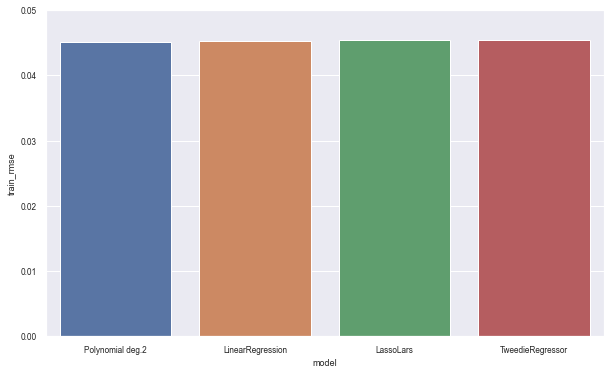

In [152]:

plt.figure(figsize = (10, 6))

sns.barplot(x = "model", y = "train_rmse", data = model_performance)
# plt.bar(x = "model", y = "validate_rmse", data = model_performance, height = 8, label = "validate")

plt.ylim(0, 0.05)
plt.show()

In [153]:
# generating validate model predictions and assigning to dataframe

lr_predictions = lr_model.predict(X_validate)
predictions["linear_predictions"] = lr_predictions.round(2)

lars_predictions = lars_model.predict(X_validate)
predictions["lars_predictions"] = lars_predictions.round(2)

glm_predictions = lars_model.predict(X_validate)
predictions["glm_predictions"] = glm_predictions.round(2)

In [154]:
# generating error reports for all models and baseline:

SSE, ESS, TSS, MSE, RMSE = acquire.get_error_report(predictions["logerror actual"], predictions["polynomial degree 2"])
print()
SSE, ESS, TSS, MSE, RMSE = acquire.get_error_report(predictions["logerror actual"], predictions["linear_predictions"])
print()
SSE, ESS, TSS, MSE, RMSE = acquire.get_error_report(predictions["logerror actual"], predictions["lars_predictions"])
print()
SSE, ESS, TSS, MSE, RMSE = acquire.get_error_report(predictions["logerror actual"], predictions["glm_predictions"])
print()
SSE, ESS, TSS, MSE, RMSE = acquire.get_error_report(predictions["logerror actual"], predictions["baseline_predictions"])

polynomial degree 2 SSE: 18.96589999999973
polynomial degree 2 ESS: 0.3599750221831463
polynomial degree 2 TSS: 19.325875022182878
polynomial degree 2 MSE: 0.0020505892528921753
polynomial degree 2 RMSE: 0.04528343243275818

linear_predictions SSE: 19.009499999999676
linear_predictions ESS: 0.3101782944411258
linear_predictions TSS: 19.319678294440802
linear_predictions MSE: 0.002055303276029806
linear_predictions RMSE: 0.04533545274980504

lars_predictions SSE: 19.255199999999714
lars_predictions ESS: 0.22903830663576807
lars_predictions TSS: 19.484238306635483
lars_predictions MSE: 0.002081868310087546
lars_predictions RMSE: 0.04562749511081609

glm_predictions SSE: 19.255199999999714
glm_predictions ESS: 0.22903830663576807
glm_predictions TSS: 19.484238306635483
glm_predictions MSE: 0.002081868310087546
glm_predictions RMSE: 0.04562749511081609

baseline_predictions SSE: 18.979299999999704
baseline_predictions ESS: 0.0
baseline_predictions TSS: 18.979299999999704
baseline_predictio

In [155]:
# checking the df

predictions.head()

logerror actual  baseline_predictions  polynomial degree 2  \
20767            -0.04                  0.00                 0.00   
29240             0.03                  0.00                -0.00   
3001              0.05                  0.00                 0.01   
45010             0.06                  0.00                 0.01   
41382             0.09                  0.00                 0.01   

       linear_predictions  lars_predictions  glm_predictions  
20767               -0.00              0.00             0.00  
29240               -0.00              0.00             0.00  
3001                 0.01              0.00             0.00  
45010                0.01              0.00             0.00  
41382                0.00              0.00             0.00